# LR multi-tissue cross-comparison

##### Ver:: A1_V5
##### Author(s) : Issac Goh
##### Date : 220823;YYMMDD
### Author notes
    - Current defaults scrpae data from web, so leave as default and run
    - slices model and anndata to same feature shape, scales anndata object
    - added some simple benchmarking
    - creates dynamic cutoffs for probability score (x*sd of mean) in place of more memory intensive confidence scoring
    - Does not have majority voting set on as default, but module does exist
    - Multinomial logistic relies on the (not always realistic) assumption of independence of irrelevant alternatives whereas a series of binary logistic predictions does not. collinearity is assumed to be relatively low, as it becomes difficult to differentiate between the impact of several variables if this is not the case
    
### Features to add
    - Add ability to consume anndata zar format for sequential learning
### Modes to run in
    - Run in training mode
    - Run in projection mode

In [23]:
import sys
import subprocess

# import pkg_resources
# required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
# installed = {pkg.key for pkg in pkg_resources.working_set}
# missing = required - installed
# if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
#from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
from pathlib import Path
import requests
import psutil
import random
import threading
import tracemalloc
import itertools
import math
import warnings
import sklearn.metrics as metrics
import harmonypy as hm

In [2]:
models = {
'pan_fetal':'/nfs/team205/ig7/resources/scripts_dont_modify/logit_regression_models/adifa_lr/celltypist_model.Pan_Fetal_Human.pkl',
'pan_fetal_wget':'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl',
'adata_scvi':'/nfs/team205/ig7/mount/gdrive/g_cloud/projects/amniontic_fluid/scvi_low_dim_model.sav',
'adata_ldvae':'/nfs/team205/ig7/mount/gdrive/g_cloud/projects/amniontic_fluid/ldvae_low_dim_model.sav',
'adata_harmony':'/nfs/team205/ig7/work_backups/backup_210306/projects/amiotic_fluid/train_low_dim_model/organ_low_dim_model.sav',
'test_low_dim_ipsc_ys':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Integrating_HM_data_030522/YS_logit/lr_model.sav',
'YS_X':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/YS_X_model_080922.sav',
'YS_X_V3':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/rebuttal_figs_010922/train_YS_full_X_model/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav',
'SK_model':'/nfs/team205/ig7/resources/scripts_dont_modify/logit_regression_models/LR_app_format/hudaa_skin/for_hudaa_A1_V2',
'Hudaa_model_trained':'/nfs/team298/hg6/Fetal_skin/LR_15012023/train-all_model.pkl',
'low_dim_sk_model':'/nfs/team205/ig7/resources/scripts_dont_modify/logit_regression_models/LR_app_format/hudaa_skin/SK_model_lowdim',
}

adatas_dict = {
'Fetal_skin_raw': '/nfs/team298/hg6/Fetal_skin/data/FS_raw_sub.h5ad',
'vascular_organoid': '/nfs/team298/hg6/Fetal_skin/data/vasc_org_raw.h5ad',
'YS':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V5_scvi_YS_integrated/A2_V5_scvi_YS_integrated_raw_qc_scr_umap.h5ad',
'YS_test':'/nfs/team205/ig7/resources/scripts_dont_modify/logit_regression_models/LR_app_format/ys_test_data.h5ad',
'YS_A2_V10_X_raw':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_raw_counts_full_no_obs.h5ad',
'YS_A2_V10_X':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw.h5ad',
'pan_f_YS_A1_V10':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/YS_panf_gonads_brain_eliv_combined_060922/A1_Vx_pan_organ_integrations/A1_V10_raw_scvi_YS_updated_panf_gonads_brain_build_donor_organ_corrected_031022.h5ad',
'pan_f_YS_A1_V10_high_var_ldvae':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/YS_panf_gonads_brain_eliv_combined_060922/ldVAE_model_projections/scvi_LDVAE_panf_pan_immune/A1_V10_raw_high_var_scvi_YS_updated_panf_gonads_brain_build_donor_organ_corrected_031022.h5ad',
'pan_f_YS_A1_V12_high_var_ldvae':'/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/YS_panf_gonads_brain_eliv_combined_060922/ldVAE_model_projections/scvi_LDVAE_panf_pan_immune/A1_V12_raw_high_var_scvi_YS_updated_panf_gonads_brain_build_donor_organ_corrected_031022.h5ad'
}

# Variable assignment
train_model = True
feat_use = 'LVL3'
adata_key = 'pan_f_YS_A1_V10'#'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local 
data_merge = False # read and merge multiple adata (useful, but keep false for now)
model_key = 'ldvae_v3_panf_model'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local 
train_x_partition = 'X_scvi' # what partition was the data trained on? To keep simple, for now only accepts 'X'
dyn_std = 1.96 # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = None #'LVL3'#'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
partial_scale = False#True # should data be scaled in batches?
QC_normalise = False#True # should data be normalised?

# training variables
penalty='elasticnet' # can be ["l1","l2","elasticnet"]
sparcity=0.5 # C penalty for degree of regularisation
thread_num = -1
l1_ratio = 0.5 # ratio between L1 and L2 regulrisatiuon depending on penatly method

# If low dim & not in keys
batch_key = 'donor'
batch_correction = False#'Harmony' #or bbknn
theta = 3 #harmony specifc

#Sketch training?
sketch_obsm = 'X_scvi'

In [3]:
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
#from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
from pathlib import Path
import requests
import psutil
import random
import threading
import tracemalloc
import itertools
import math
import warnings
import sklearn.metrics as metrics

def load_models(model_dict,model_run):
    if (Path(model_dict[model_run])).is_file():
        # Load data (deserialize)
        model = pkl.load(open(model_dict[model_run], "rb"))
        return model
    elif 'http' in model_dict[model_run]:
        print('Loading model from web source')
        r_get = requests.get(model_dict[model_run])
        fpath = './model_temp.sav'
        open(fpath , 'wb').write(r_get.content)
        model = pkl.load(open(fpath, "rb"))
        return model

def load_adatas(adatas_dict,data_merge, data_key_use,QC_normalise):
    if data_merge == True:
        # Read
        gene_intersect = {} # unused here
        adatas = {}
        for dataset in adatas_dict.keys():
            if 'https' in adatas_dict[dataset]:
                print('Loading anndata from web source')
                adatas[dataset] = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[dataset])
            adatas[dataset] = sc.read(data[dataset])
            adatas[dataset].var_names_make_unique()
            adatas[dataset].obs['dataset_merge'] = dataset
            adatas[dataset].obs['dataset_merge'] = dataset
            gene_intersect[dataset] = list(adatas[dataset].var.index)
        adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],join='inner')
        return adatas, adata
    elif data_merge == False:
        if 'https' in adatas_dict[data_key_use]:
            print('Loading anndata from web source')
            adata = sc.read('./temp_adata.h5ad',backup_url=adatas_dict[data_key_use])
        else: 
            adata = sc.read(adatas_dict[data_key_use])
    if QC_normalise == True:
        print('option to apply standardisation to data detected, performing basic QC filtering')
        sc.pp.filter_cells(adata, min_genes=200)
        sc.pp.filter_genes(adata, min_cells=3)
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        sc.pp.log1p(adata)
        
    return adata

# resource usage logger
class DisplayCPU(threading.Thread):
    def run(self):
        tracemalloc.start()
        starting, starting_peak = tracemalloc.get_traced_memory()
        self.running = True
        self.starting = starting
        currentProcess = psutil.Process()
        cpu_pct = []
        peak_cpu = 0
        while self.running:
            peak_cpu = 0
#           time.sleep(3)
#             print('CPU % usage = '+''+ str(currentProcess.cpu_percent(interval=1)))
#             cpu_pct.append(str(currentProcess.cpu_percent(interval=1)))
            cpu = currentProcess.cpu_percent()
        # track the peak utilization of the process
            if cpu > peak_cpu:
                peak_cpu = cpu
                peak_cpu_per_core = peak_cpu/psutil.cpu_count()
        self.peak_cpu = peak_cpu
        self.peak_cpu_per_core = peak_cpu_per_core
        
    def stop(self):
#        cpu_pct = DisplayCPU.run(self)
        self.running = False
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        return current, peak
    
# projection module
def reference_projection(adata, model, dyn_std,partial_scale):
    
    class adata_temp:
        pass
    from sklearn.preprocessing import StandardScaler
    print('Determining model flavour')
    try:
        model_lr =  model['Model']
        print('Consuming celltypist model')
    except:# hasattr(model, 'coef_'):
        print('Consuming non-celltypist model')
        model_lr =  model
    print(model_lr)
    
#     model_lr =  model['Model']

    if train_x_partition == 'X':
        print('Matching reference genes in the model')
        k_x = np.isin(list(adata.var.index), list(model_lr.features))
        if k_x.sum() == 0:
            raise ValueError(f"🛑 No features overlap with the model. Please provide gene symbols")
        print(f"🧬 {k_x.sum()} features used for prediction")
        #slicing adata
        k_x_idx = np.where(k_x)[0]
        # adata_temp = adata[:,k_x_idx]
        adata_temp.var = adata[:,k_x_idx].var
        adata_temp.X = adata[:,k_x_idx].X
        adata_temp.obs = adata[:,k_x_idx].obs
        lr_idx = pd.DataFrame(model_lr.features, columns=['features']).reset_index().set_index('features').loc[list(adata_temp.var.index)].values
        # adata_arr = adata_temp.X[:,list(lr_idexes['index'])]

        # slice and reorder model
        ni, fs, cf = model_lr.n_features_in_, model_lr.features, model_lr.coef_
        model_lr.n_features_in_ = lr_idx.size
        model_lr.features = np.array(model_lr.features)[lr_idx]
        model_lr.coef_ = np.squeeze(model_lr.coef_[:,lr_idx]) #model_lr.coef_[:, lr_idx]
        
        if partial_scale == True:
            print('scaling input data, default option is to use incremental learning and fit in mini bulks!')
            # Partial scaling alg
            scaler = StandardScaler(with_mean=False)
            n = adata_temp.X.shape[0]  # number of rows
            # set dyn scale packet size
            x_len = len(adata_temp.var)
            y_len = len(adata.obs)
            if y_len < 100000:
                dyn_pack = int(x_len/10)
                pack_size = dyn_pack
            else:
                # 10 pack for every 100,000
                dyn_pack = int((y_len/100000)*10)
                pack_size = int(x_len/dyn_pack)

            batch_size =  1000#pack_size#500  # number of rows in each call to partial_fit
            index = 0  # helper-var
            while index < n:
                partial_size = min(batch_size, n - index)  # needed because last loop is possibly incomplete
                partial_x = adata_temp.X[index:index+partial_size]
                scaler.partial_fit(partial_x)
                index += partial_size
            adata_temp.X = scaler.transform(adata_temp.X)
    else:
        adata_temp = adata[:]
    # model projections
    print('Starting reference projection!')
    if train_x_partition == 'X':
        train_x = adata_temp.X
        pred_out = pd.DataFrame(model_lr.predict(train_x),columns = ['predicted'],index = list(adata.obs.index))
        proba =  pd.DataFrame(model_lr.predict_proba(train_x),columns = model_lr.classes_,index = list(adata.obs.index))
        pred_out = pred_out.join(proba)
        
    elif train_x_partition in list(adata_temp.obsm.keys()): 
        print('{low_dim: this partition modality is still under development!}')
        train_x = adata_temp.obsm[train_x_partition][:]
        pred_out = pd.DataFrame(model_lr.predict(train_x),columns = ['predicted'],index = list(adata.obs.index))
        proba =  pd.DataFrame(model_lr.predict_proba(train_x),columns = model_lr.classes_,index = list(adata.obs.index))
        pred_out = pred_out.join(proba)

    
    else:
        print('{this partition modality is still under development!}')
        print('Warning! No obsm partition detected! defaulting to PCA, if this is not self-projection, do not use the results!')
        if not 'X_pca' in adata.obsm.keys():
            print('performing highly variable gene selection')
            sc.pp.highly_variable_genes(adata_temp, batch_key = batch_key, subset=False)
            sc.pp.pca(adata_temp, n_comps=100, use_highly_variable=True, svd_solver='arpack')
            sc.pl.pca_variance_ratio(adata_temp, log=True,n_pcs=100)
            train_x = adata_temp.obsm['X_pca'][:]
            pred_out = pd.DataFrame(model_lr.predict(train_x),columns = ['predicted'],index = list(adata.obs.index))
            proba =  pd.DataFrame(model_lr.predict_proba(train_x),columns = model_lr.classes_,index = list(adata.obs.index))
            pred_out = pred_out.join(proba)

    # Simple dynamic confidence calling
    pred_out['confident_calls'] = pred_out['predicted']
    pred_out.loc[pred_out.max(axis=1)<(pred_out.mean(axis=1) + (1*pred_out.std(axis=1))),'confident_calls'] = pred_out.loc[pred_out.max(axis=1)<(pred_out.mean(axis=1) + (1*pred_out.std(axis=1))),'confident_calls'].astype(str) + '_uncertain'
    # means_ = self.model.scaler.mean_[lr_idx] if self.model.scaler.with_mean else 0
    return(pred_out,train_x,model_lr,adata_temp)

def freq_redist_68CI(adata,clusters_reassign):
    if freq_redist != False:
        print('Frequency redistribution commencing')
        cluster_prediction = "consensus_clus_prediction"
        lr_predicted_col = 'predicted'
        pred_out[clusters_reassign] = adata.obs[clusters_reassign].astype(str)
        reassign_classes = list(pred_out[clusters_reassign].unique())
        lm = 1 # lambda value
        pred_out[cluster_prediction] = pred_out[clusters_reassign]
        for z in pred_out[clusters_reassign][pred_out[clusters_reassign].isin(reassign_classes)].unique():
            df = pred_out
            df = df[(df[clusters_reassign].isin([z]))]
            df_count = pd.DataFrame(df[lr_predicted_col].value_counts())
            # Look for classificationds > 68CI
            if len(df_count) > 1:
                df_count_temp = df_count[df_count[lr_predicted_col]>int(int(df_count.mean()) + (df_count.std()*lm))]
                if len(df_count_temp >= 1):
                    df_count = df_count_temp
            #print(df_count)     
            freq_arranged = df_count.index
            cat = freq_arranged[0]
        #Make the cluster assignment first
            pred_out[cluster_prediction] = pred_out[cluster_prediction].astype(str)
            pred_out.loc[pred_out[clusters_reassign] == z, [cluster_prediction]] = cat
        # Create assignments for any classification >68CI
            for cats in freq_arranged:
                #print(cats)
                cats_assignment = cats#.replace(data1,'') + '_clus_prediction'
                pred_out.loc[(pred_out[clusters_reassign] == z) & (pred_out[lr_predicted_col] == cats),[cluster_prediction]] = cats_assignment
        min_counts = pd.DataFrame((pred_out[cluster_prediction].value_counts()))
        reassign = list(min_counts.index[min_counts[cluster_prediction]<=2])
        pred_out[cluster_prediction] = pred_out[cluster_prediction].str.replace(str(''.join(reassign)),str(''.join(pred_out.loc[pred_out[clusters_reassign].isin(list(pred_out.loc[(pred_out[cluster_prediction].isin(reassign)),clusters_reassign])),lr_predicted_col].value_counts().head(1).index.values)))
        return pred_out

### Feature importance notes
#- If we increase the x feature one unit, then the prediction will change e to the power of its weight. We can apply this rule to the all weights to find the feature importance.
#- We will calculate the Euler number to the power of its coefficient to find the importance.
#- To sum up an increase of x feature by one unit increases the odds of being versicolor class by a factor of x[importance] when all other features remain the same.

#- For low-dim, we look at the distribution of e^coef per class, we extract the 


# class coef_extract:
#     def __init__(self, model,features, pos):
# #         self.w = list(itertools.chain(*(model.coef_[pos]).tolist())) #model.coef_[pos]
#         self.w = model.coef_[class_pred_pos]
#         self.features = features 

def long_format_features(top_loadings):
    p = top_loadings.loc[:, top_loadings.columns.str.endswith("_e^coef")]
    p = pd.melt(p)
    n = top_loadings.loc[:, top_loadings.columns.str.endswith("_feature")]
    n = pd.melt(n)
    l = top_loadings.loc[:, top_loadings.columns.str.endswith("_coef")]
    l = pd.melt(l)
    n = n.replace(regex=r'_feature', value='')
    n = n.rename(columns={"variable": "class", "value": "feature"})
    p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "e^coef"})
    l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "coef"})
    concat = pd.concat([n,p,l],axis=1)
    return concat

def model_feature_sf(long_format_feature_importance, coef_use):
        long_format_feature_importance[str(coef_use) + '_pval'] = 'NaN'
        for class_lw in long_format_feature_importance['class'].unique():
            df_loadings = long_format_feature_importance[long_format_feature_importance['class'].isin([class_lw])]
            comps = coef_use #'e^coef'
            U = np.mean(df_loadings[comps])
            std = np.std(df_loadings[comps])
            med =  np.median(df_loadings[comps])
            mad = np.median(np.absolute(df_loadings[comps] - np.median(df_loadings[comps])))
            # Survival function scaled by 1.4826 of MAD (approx norm)
            pvals = scipy.stats.norm.sf(df_loadings[comps], loc=med, scale=1.4826*mad) # 95% CI of MAD <10,000 samples
            #pvals = scipy.stats.norm.sf(df_loadings[comps], loc=U, scale=1*std)
            df_loadings[str(comps) +'_pval'] = pvals
            long_format_feature_importance.loc[long_format_feature_importance.index.isin(df_loadings.index)] = df_loadings
        long_format_feature_importance['is_significant_sf'] = False
        long_format_feature_importance.loc[long_format_feature_importance[coef_use+ '_pval']<0.05,'is_significant_sf'] = True
        return long_format_feature_importance
# Apply SF to e^coeff mat data
#         pval_mat = pd.DataFrame(columns = mat.columns)
#         for class_lw in mat.index:
#             df_loadings = mat.loc[class_lw]
#             U = np.mean(df_loadings)
#             std = np.std(df_loadings)
#             med =  np.median(df_loadings)
#             mad = np.median(np.absolute(df_loadings - np.median(df_loadings)))
#             pvals = scipy.stats.norm.sf(df_loadings, loc=med, scale=1.96*U)

class estimate_important_features: # This calculates feature effect sizes of the model
    def __init__(self, model, top_n):
        print('Estimating feature importance')
        classes =  list(model.classes_)
         # get feature names
        try:
            model_features = list(itertools.chain(*list(model.features)))
        except:
            warnings.warn('no features recorded in data, naming features by position')
            print('if low-dim lr was submitted, run linear decoding function to obtain true feature set')
            model_features = list(range(0,model.coef_.shape[1]))
            model.features = model_features
        print('Calculating the Euler number to the power of coefficients')
        impt_ = pow(math.e,model.coef_)
        try:
            self.euler_pow_mat = pd.DataFrame(impt_,columns = list(itertools.chain(*list(model.features))),index = list(model.classes_))
        except:
            self.euler_pow_mat = pd.DataFrame(impt_,columns = list(model.features),index = list(model.classes_))
        self.top_n_features = pd.DataFrame(index = list(range(0,top_n)))
        # estimate per class feature importance
        
        print('Estimating feature importance for each class')
        mat = self.euler_pow_mat
        for class_pred_pos in list(range(0,len(mat.T.columns))):
            class_pred = list(mat.T.columns)[class_pred_pos]
            #     print(class_pred)
            temp_mat =  pd.DataFrame(mat.T[class_pred])
            temp_mat['coef'] = model.coef_[class_pred_pos]
            temp_mat = temp_mat.sort_values(by = [class_pred], ascending=False)
            temp_mat = temp_mat.reset_index()
            temp_mat.columns = ['feature','e^coef','coef']
            temp_mat = temp_mat[['feature','e^coef','coef']]
            temp_mat.columns =str(class_pred)+ "_" + temp_mat.columns
            self.top_n_features = pd.concat([self.top_n_features,temp_mat.head(top_n)], join="inner",ignore_index = False, axis=1)
            self.to_n_features_long = model_feature_sf(long_format_features(self.top_n_features),'e^coef')
            
    
    # plot class-wise features
def model_class_feature_plots(top_loadings, classes, comps):
    import matplotlib.pyplot as plt
    for class_temp in classes:
        class_lw = class_temp
        long_format = top_loadings
        df_loadings = long_format[long_format['class'].isin([class_lw])]
        plt.hist(df_loadings[comps])
        for i in ((df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]).unique()):
            plt.axvline(x=i,color='red')
        med = np.median(df_loadings[comps])
        plt.axvline(x=med,color='blue')
        plt.xlabel('feature_importance', fontsize=12)
        plt.title(class_lw)
        #plt.axvline(x=med,color='pink')
        df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]
        print(len(df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]))
        #Plot feature ranking
        plot_loading = pd.DataFrame(pd.DataFrame(df_loadings[comps][df_loadings[str(comps) +'_pval']<0.05]).iloc[:,0].sort_values(ascending=False))
        table = plt.table(cellText=plot_loading.values,colWidths = [1]*len(plot_loading.columns),
        rowLabels= list(df_loadings['feature'][df_loadings.index.isin(plot_loading.index)].reindex(plot_loading.index)), #plot_loading.index,
        colLabels=plot_loading.columns,
        cellLoc = 'center', rowLoc = 'center',
        loc='right', bbox=[1.4, -0.05, 0.5,1])
        table.scale(1, 2)
        table.set_fontsize(10)
        
def report_f1(model,train_x, train_label):
    ## Report accuracy score
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn import metrics
    import seaborn as sn
    import pandas as pd
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    
    # cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
    # # evaluate the model and collect the scores
    # n_scores = cross_val_score(lr, train_x, train_label, scoring='accuracy', cv=cv, n_jobs=-1)
    # # report the model performance
    # print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

    # Report Precision score
    metric = pd.DataFrame((metrics.classification_report(train_label, model.predict(train_x), digits=2,output_dict=True))).T
    cm = confusion_matrix(train_label, model.predict(train_x))
    #cm = confusion_matrix(train_label, model.predict_proba(train_x))
    df_cm = pd.DataFrame(cm, index = model.classes_,columns = model.classes_)
    df_cm = (df_cm / df_cm.sum(axis=0))*100
    plt.figure(figsize = (20,20))
    sn.set(font_scale=1) # for label size
    pal = sns.diverging_palette(240, 10, n=10)
    #plt.suptitle(('Mean Accuracy 5 fold: %.3f std: %.3f' % (np.mean(n_scores),  np.std(n_scores))), y=1.05, fontsize=18)
    #Plot precision recall and recall
    table = plt.table(cellText=metric.values,colWidths = [1]*len(metric.columns),
    rowLabels=metric.index,
    colLabels=metric.columns,
    cellLoc = 'center', rowLoc = 'center',
    loc='bottom', bbox=[0.25, -0.6, 0.5, 0.3])
    table.scale(1, 2)
    table.set_fontsize(5)
    g = sn.heatmap(df_cm, annot=False, annot_kws={"size": 16},cmap=pal) # font size
    print(metrics.classification_report(train_label, model.predict(train_x), digits=2))
    plt.show()
    return metric
    
    
def subset_top_hvgs(adata_lognorm, n_top_genes):
    dispersion_norm = adata_lognorm.var['dispersions_norm'].values.astype('float32')

    dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
    dispersion_norm[
                ::-1
            ].sort()  # interestingly, np.argpartition is slightly slower

    disp_cut_off = dispersion_norm[n_top_genes - 1]
    gene_subset = adata_lognorm.var['dispersions_norm'].values >= disp_cut_off
    return(adata_lognorm[:,gene_subset])

def prep_scVI(adata, 
              n_hvgs = 5000,
              remove_cc_genes = True,
              remove_tcr_bcr_genes = False
             ):
    ## Remove cell cycle genes
    if remove_cc_genes:
        adata = panfetal_utils.remove_geneset(adata,genes.cc_genes)

    ## Remove TCR/BCR genes
    if remove_tcr_bcr_genes:
        adata = panfetal_utils.remove_geneset(adata, genes.IG_genes)
        adata = panfetal_utils.remove_geneset(adata, genes.TCR_genes)
        
    ## HVG selection
    adata = subset_top_hvgs(adata, n_top_genes=n_hvgs)
    return(adata)

# Modified LR train module, does not work with low-dim by default anymore, please use low-dim adapter
def LR_train(adata, train_x, train_label, penalty='elasticnet', sparcity=0.2,max_iter=200,l1_ratio =0.2,tune_hyper_params =False,n_splits=5, n_repeats=3,l1_grid = [0.05,0.2,0.5], c_grid = [0.05,0.2,0.4],sketch_obsm =None):
    if tune_hyper_params == True:
        train_labels = train_label
        results,adata_tuned = tune_lr_model(adata, train_x_partition = train_x, random_state = 42,  train_labels = train_labels, n_splits=n_splits, n_repeats=n_repeats,l1_grid = l1_grid, c_grid = c_grid,sketch_obsm = sketch_obsm)
        print('hyper_params tuned')
        sparcity = results.best_params_['C']
        l1_ratio = results.best_params_['l1_ratio']
        
    if not sketch_obsm == None:
        #sketch data
        try:
            adata = sketch_data(adata, train_x_partition = train_x, random_state = 42,  train_labels = train_label,sketch_obsm = sketch_obsm)
        except:
            print()

    lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, n_jobs=thread_num)
    if (penalty == "l1"):
        lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, dual = True, solver = 'liblinear',multi_class = 'ovr', n_jobs=thread_num ) # one-vs-rest
    if (penalty == "elasticnet"):
        lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, dual=False,solver = 'saga',l1_ratio=l1_ratio,multi_class = 'ovr', n_jobs=thread_num)
    if train_x == 'X':
        subset_train = adata.obs.index
        # Define training parameters
        train_label = adata.obs[train_label].values
#        predict_label = train_label[subset_predict]
#        train_label = train_label[subset_train]
        train_x = adata.X#[adata.obs.index.isin(list(adata.obs[subset_train].index))]
#        predict_x = adata.X[adata.obs.index.isin(list(adata.obs[subset_predict].index))]
        model = lr.fit(train_x, train_label)
        model.features = np.array(adata.var.index)
    elif train_x in adata.obsm.keys():
        print('train with obsm')
        # Define training parameters
        train_label = adata.obs[train_label].values
#        predict_label = train_label[subset_predict]
#         train_label = train_label[subset_train]
        train_x = adata.obsm[train_x]
#        predict_x = train_x
#        train_x = train_x[subset_train, :]
        # Define prediction parameters
#        predict_x = predict_x[subset_predict]
#        predict_x = pd.DataFrame(predict_x)
#        predict_x.index = adata.obs[subset_predict].index
    # Train predictive model using user defined partition labels (train_x ,train_label, predict_x)
        model = lr.fit(train_x, train_label)
        model.features = list(pd.DataFrame(train_x).columns)
        #model.features = list(range()) list(pd.DataFrame(adata.obsm[train_x]).columns)
    return model

def tune_lr_model(adata, train_x_partition = 'X', random_state = 42,  train_labels = None, n_splits=5, n_repeats=3,l1_grid = [0.05,0.2,0.5], c_grid = [0.05,0.2,0.4],sketch_obsm = None):
    import bless as bless
    from sklearn.gaussian_process.kernels import RBF
    from numpy import arange
    from sklearn.model_selection import RepeatedKFold
    from sklearn.datasets import make_classification
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score
    from sklearn.model_selection import GridSearchCV

    # If latent rep is provided, randomly sample data in spatially aware manner for initialisation
    r = np.random.RandomState(random_state)
    if train_x_partition in adata.obsm.keys():
        tune_train_x = adata.obsm[train_x_partition][:]
        lvg = bless.bless(tune_train_x, RBF(length_scale=20), lam_final = 2, qbar = 10, random_state = r, H = 10, force_cpu=True)
        adata_tuning = adata[lvg.idx]
        if not train_labels == None:
            tune_train_label = adata_tuning.obs[train_labels]
            orig_labels = adata.obs[train_labels]
            # check if all labels are preserved
            non_int = len(list(set(tune_train_label)^set(orig_labels)))
            if ((non_int)) > 0 :
                print('{} labels lost in sketch, attempting re-sketch'.format(non_int))
                counter = 1
                while counter < 5:
                    q_bar = 10 + (5*counter)
                    lvg = bless.bless(tune_train_x, RBF(length_scale=20), lam_final = 2, qbar = q_bar, random_state = r, H = 10, force_cpu=True)
                    adata_tuning = adata[lvg.idx]
                    tune_train_label = adata_tuning.obs[train_labels]
                    non_int = len(list(set(tune_train_label)^set(orig_labels)))
                    if non_int > 0:
                        counter = counter + 1
                    else:
                        counter = 5
        tune_train_x = adata_tuning.obsm[sketch_obsm][:]
        print('Sketched data is {} long'.format(len(adata_tuning.obs)))

    elif sketch_obsm in adata.obsm.keys():
        sketch_obsm_id = adata.obsm[sketch_obsm][:]
        lvg = bless.bless(sketch_obsm_id, RBF(length_scale=20), lam_final = 2, qbar = 10, random_state = r, H = 10, force_cpu=True)
        adata_tuning = adata[lvg.idx]
        if not train_labels == None:
            tune_train_label = adata_tuning.obs[train_labels]
            orig_labels = adata.obs[train_labels]
            # check if all labels are preserved
            non_int = len(list(set(tune_train_label)^set(orig_labels)))
            if ((non_int)) > 0 :
                print('{} labels lost in sketch, attempting re-sketch'.format(non_int))
                counter = 1
                while counter < 5:
                    q_bar = 10 + (5*counter)
                    lvg = bless.bless(tune_train_x, RBF(length_scale=20), lam_final = 2, qbar = q_bar, random_state = r, H = 10, force_cpu=True)
                    adata_tuning = adata[lvg.idx]
                    tune_train_label = adata_tuning.obs[train_labels]
                    non_int = len(list(set(tune_train_label)^set(orig_labels)))
                    if non_int > 0:
                        counter = counter + 1
                    else:
                        counter = 5          
        print('Sketched data is {} long'.format(len(adata_tuning.obs)))
        tune_train_x = adata_tuning.obsm[sketch_obsm][:]
    #     try:
    #         import cupy
    #         lvg_2 = bless(adata.obsm[train_x_partition], RBF(length_scale=10), 10, 10, r, 10, force_cpu=False)
    #     except ImportError:
    #         print("cupy not found, defaulting to numpy")
    else:
        print('no latent representation provided, random sampling instead')
        prop = 0.1
        random_vertices = []
        n_ixs = int(len(adata.obs) * prop)
        random_vertices = random.sample(list(range(len(adata.obs))), k=n_ixs)
        adata_tuning = adata[random_vertices]
        tune_train_x = adata_tuning.X
        
    if not train_labels == None:
        tune_train_label = adata_tuning.obs[train_labels]
    elif train_labels == None:
        try:
            print('no training labels provided, defaulting to unsuperived leiden clustering, updates will change this to voronoi greedy sampling')
            sc.tl.leiden(adata_tuning)
        except:
            print('no training labels provided, no neighbors, defaulting to unsuperived leiden clustering, updates will change this to voronoi greedy sampling')
            sc.pp.neighbors(adata_hm, n_neighbors=15, n_pcs=50)
            sc.tl.leiden(adata_tuning)
        tune_train_label = adata_tuning.obs['leiden']
    ## tune regularization for multinomial logistic regression
    print('starting tuning loops')
    X = tune_train_x
    y = tune_train_label
    grid = dict()
    # define model
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    #model = LogisticRegression(penalty = penalty, max_iter =  200, dual=False,solver = 'saga', multi_class = 'multinomial',)
    model = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  500, n_jobs=4)
    if (penalty == "l1"):
        model = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  500, dual = True, solver = 'liblinear',multi_class = 'ovr', n_jobs=4 ) # one-vs-rest
    if (penalty == "elasticnet"):
        model = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  500, dual=False,solver = 'saga',l1_ratio=l1_ratio,multi_class = 'ovr', n_jobs=4) # use multinomial class if probabilities are descrete
        grid['l1_ratio'] = l1_grid
    grid['C'] = c_grid
    # define search
    search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # perform the search
    results = search.fit(X, y)
    # summarize
    print('MAE: %.3f' % results.best_score_)
    print('Config: %s' % results.best_params_)
    return results , adata_tuning

def prep_training_data(adata_temp,feat_use,batch_key, model_key, batch_correction=False, var_length = 7500,penalty='elasticnet',sparcity=0.2,max_iter = 200,l1_ratio = 0.1,partial_scale=True,train_x_partition ='X',theta = 3,tune_hyper_params=False,sketch_obsm = None ):
    model_name = model_key + '_lr_model'
    print('performing highly variable gene selection')
    #sc.pp.highly_variable_genes(adata_temp, batch_key = batch_key, subset=False)
#     #temp inclusion
#     sc.pp.pca(adata_temp, n_comps=100, use_highly_variable=True, svd_solver='arpack')
#     sc.pl.pca_variance_ratio(adata_temp, log=True,n_pcs=100)
        
    adata_temp = adata_temp#subset_top_hvgs(adata_temp,var_length)
    #scale the input data
    if partial_scale == True:
        print('scaling input data, default option is to use incremental learning and fit in mini bulks!')
        # Partial scaling alg
        #adata_temp.X = (adata_temp.X)
        scaler = StandardScaler(with_mean=False)
        n = adata_temp.X.shape[0]  # number of rows
        # set dyn scale packet size
        x_len = len(adata_temp.var)
        y_len = len(adata_temp.obs)
        if y_len < 100000:
            dyn_pack = int(x_len/10)
            pack_size = dyn_pack
        else:
            # 10 pack for every 100,000
            dyn_pack = int((y_len/100000)*10)
            pack_size = int(x_len/dyn_pack)
        batch_size =  1000#pack_size#500  # number of rows in each call to partial_fit
        index = 0  # helper-var
        while index < n:
            partial_size = min(batch_size, n - index)  # needed because last loop is possibly incomplete
            partial_x = adata_temp.X[index:index+partial_size]
            scaler.partial_fit(partial_x)
            index += partial_size
        adata_temp.X = scaler.transform(adata_temp.X)
#     else:
#         sc.pp.scale(adata_temp, zero_center=True, max_value=None, copy=False, layer=None, obsm=None)

    if (train_x_partition != 'X') & (train_x_partition not in adata_temp.obsm.keys()):
        print('train partition is not in OBSM, defaulting to PCA')
        # Now compute PCA
        sc.pp.pca(adata_temp, n_comps=100, use_highly_variable=True, svd_solver='arpack')
        sc.pl.pca_variance_ratio(adata_temp, log=True,n_pcs=100)
        
        # Batch correction options
        # The script will test later which Harmony values we should use 
        if(batch_correction == "Harmony"):
            print("Commencing harmony")
            if len(batch_key) == 1:
                adata_temp.obs['lr_batch'] = adata_temp.obs[batch_key]
                batch_var = "lr_batch"
            else:
                batch_var = batch_key
            # Create hm subset
            adata_hm = adata_temp[:]
            # Set harmony variables
            data_mat = np.array(adata_hm.obsm["X_pca"])
            meta_data = adata_hm.obs
            vars_use = [batch_var]
            # Run Harmony
            ho = hm.run_harmony(data_mat, meta_data, vars_use,theta=theta)
            res = (pd.DataFrame(ho.Z_corr)).T
            res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
            # Insert coordinates back into object
            adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
            adata_hm.obsm["X_pca"] = np.array(res)
            # Run neighbours
            #sc.pp.neighbors(adata_hm, n_neighbors=15, n_pcs=50)
            adata_temp = adata_hm[:]
            del adata_hm
        elif(batch_correction == "BBKNN"):
            print("Commencing BBKNN")
            sc.external.pp.bbknn(adata_temp, batch_key=batch_var, approx=True, metric='angular', copy=False, n_pcs=50, trim=None, n_trees=10, use_faiss=True, set_op_mix_ratio=1.0, local_connectivity=15) 

    # train model
#    train_x = adata_temp.X
    #train_label = adata_temp.obs[feat_use]
    print('proceeding to train model')
    model = LR_train(adata_temp, train_x = train_x_partition, train_label=feat_use, penalty=penalty, sparcity=sparcity,max_iter=max_iter,l1_ratio = l1_ratio,tune_hyper_params = tune_hyper_params,sketch_obsm = sketch_obsm)
#     model.features = list(adata_temp.var.index)
    return model

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def sketch_data(adata, train_x_partition = 'X', sketch_obsm = None, random_state = 42,  train_labels = None):
    import bless as bless
    from sklearn.gaussian_process.kernels import RBF
    from numpy import arange
    from sklearn.model_selection import RepeatedKFold
    from sklearn.datasets import make_classification
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score
    from sklearn.model_selection import GridSearchCV

    # If latent rep is provided, randomly sample data in spatially aware manner for initialisation
    r = np.random.RandomState(random_state)
    if train_x_partition in adata.obsm.keys():
        tune_train_x = adata.obsm[train_x_partition][:]
    elif sketch_obsm in adata.obsm.keys():
        tune_train_x = adata.obsm[sketch_obsm][:]
    else:
        print('No obsm partition detected! defaulting to PCA')
        if not 'X_pca' in adata.obsm.keys():
            print('performing highly variable gene selection')
            sc.pp.highly_variable_genes(adata_temp, batch_key = batch_key, subset=False)
            sc.pp.pca(adata_temp, n_comps=100, use_highly_variable=True, svd_solver='arpack')
            sc.pl.pca_variance_ratio(adata_temp, log=True,n_pcs=100)
        tune_train_x = adata.obsm['X_pca'][:]
    lvg = bless.bless(tune_train_x, RBF(length_scale=20), lam_final = 2, qbar = 2, random_state = r, H = 10, force_cpu=True)
    adata_tuning = adata[lvg.idx]
    print('sketched partition is {}, original is {}'.format(len(lvg.idx)),len(adata.obs))
    return adata_tuning

# Create linearly decoded latent representation

In [ ]:
adata.obs['chemistry_ver'] = 'V1'
adata.obs.loc[adata.obs['orig.dataset'].isin(['YS_WE']),'chemistry_ver'] = 'V2'
adata.obs['lr_batch'] = adata.obs['fetal.ids'].astype(str) + '_' + adata.obs['chemistry_ver'].astype(str)  + '_' + adata.obs['donor'].astype(str) 

arches_params = dict(
encode_covariates=True,
dropout_rate=0.2,
n_layers=2,
n_hidden=256)

scvi.model.LinearSCVI.setup_anndata(
adata,
labels_key = 'LVL3',
layer=None,
batch_key='lr_batch')

vae = scvi.model.LinearSCVI(adata, n_latent=30, **arches_params)
#vae = scvi.model.SCVI(adata, n_latent=30,n_hidden=256, **arches_params)
vae.train(early_stopping=True,
    train_size=0.9,
    early_stopping_patience=45,
    max_epochs=500, 
    batch_size=1024, 
    limit_train_batches=20
   )
X_scvi = vae.get_latent_representation()
X_loading = vae.get_loadings()
adata.obsm['X_scvi'] = X_scvi
adata.varm['X_scvi'] = X_loading

adata.write('/home/jupyter/mount/gdrive/g_cloud/projects/YS/data/panf_ys_brain_eliv/A1_V11_ldvae_scvi_YS_updated_panf_gonads_brain_build_donor_organ_corrected_031022.h5ad')

# save the latent representation and varm compartment
pd.DataFrame(adata.obsm['X_scvi'],index = adata.obs.index).to_csv('./scvi_YS_lt_vae_outs_150522_v7.csv')
pd.DataFrame(adata.varm['X_scvi'],index = adata.obs.index).to_csv('./scvi_YS_lt_varm_outs_150522_v7.csv")

# save the reference model
vae.save(dir_path = (save_path + run_id), overwrite=False, save_anndata=False)

## Save training stats
model_history = vae.history.copy()
model_history.pop('train_loss_step')
pd.DataFrame.from_dict({k:v[k] for k,v in model_history.items()}).to_csv("panf_data_raw_count.{t}.scVI_out.train_history.csv".format(t=timestamp))

# Train a LR model based on highly variable feature selection (gene expression)

In [ ]:
train_x_partition = 'X'
if train_model == True:
    from sklearn.preprocessing import StandardScaler
    adata =  load_adatas(adatas_dict, data_merge, adata_key,QC_normalise)
    print('adata_loaded')
    sc.pp.highly_variable_genes(adata, batch_key = batch_key, subset=False)
    sc.pp.pca(adata, n_comps=100, use_highly_variable=True, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)
    adata_orig = adata.copy()
    import time
    t0 = time.time()
    display_cpu = DisplayCPU()
    display_cpu.start()
    try:
        model_trained = prep_training_data(feat_use = feat_use,
        adata_temp = adata,
        train_x_partition = train_x_partition,
        model_key = model_key + '_lr_model',
        batch_correction = False,
        var_length = 7500,
        batch_key = None, #batch_key,
        penalty='elasticnet', # can be ["l1","l2","elasticnet"],
        sparcity=0.1, #If using LR without optimisation, this controls the sparsity in model
        max_iter = 1000, #Increase if experiencing max iter issues
        l1_ratio = 0.1, #If using elasticnet without optimisation, this controls the ratio between l1 and l2)
        partial_scale = False, #partial_scale,
        tune_hyper_params = False, # Current implementation is very expensive, intentionally made rigid for now
        sketch_obsm = sketch_obsm
        )
        filename = model_key
        pkl.dump(model_trained, open(filename, 'wb'))
        models[model_key] = model_key
    finally: #
        current, peak = display_cpu.stop()
        t1 = time.time()
        time_s = t1-t0
        print('training complete!')
        time.sleep(3)
        print('projection time was ' + str(time_s) + ' seconds')
        print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
        print(f"starting memory usage is" +'' + str(display_cpu.starting))
        print('peak CPU % usage = '+''+ str(display_cpu.peak_cpu))
        print('peak CPU % usage/core = '+''+ str(display_cpu.peak_cpu_per_core))
    model_lr = model_trained
    #adata = adata_orig.copy()
    #adata =  load_adatas(adatas_dict, data_merge, adata_key,QC_normalise)
else:
    adata =  load_adatas(adatas_dict, data_merge, adata_key,QC_normalise)
    model = load_models(models,model_key)
    model_lr =  model
# run with usage logger
import time
t0 = time.time()
display_cpu = DisplayCPU()
display_cpu.start()
try: #code here ##
    pred_out,train_x,model_lr,adata_temp = reference_projection(adata, model_lr, dyn_std,partial_scale)
    if freq_redist != False:
        pred_out = freq_redist_68CI(adata,freq_redist)
        pred_out['orig_labels'] = adata.obs[freq_redist]
        adata.obs['consensus_clus_prediction'] = pred_out['consensus_clus_prediction']
    adata.obs['predicted'] = pred_out['predicted']
    adata_temp.obs = adata.obs
    
    # Estimate top model features for class descrimination
    feature_importance = estimate_important_features(model_lr, 100)
    mat = feature_importance.euler_pow_mat
    top_loadings = feature_importance.to_n_features_long
    
    # Estimate dataset specific feature impact
#     for classes in ['pDC precursor_ys_HL','AEC_ys_HL']:
#         model_class_feature_plots(top_loadings, [str(classes)], 'e^coef')
#         plt.show()
finally: #
    current, peak = display_cpu.stop()
t1 = time.time()
time_s = t1-t0
print('projection complete!')
time.sleep(3)
print('projection time was ' + str(time_s) + ' seconds')
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
print(f"starting memory usage is" +'' + str(display_cpu.starting))
print('peak CPU % usage = '+''+ str(display_cpu.peak_cpu))
print('peak CPU % usage/core = '+''+ str(display_cpu.peak_cpu_per_core))

# regression summary
idx_map = dict(zip(  list(adata.obs[feat_use].unique()),list(range(0,len(list(adata.obs[feat_use].unique()))))))
regression_results(adata.obs[feat_use].map(idx_map), adata.obs['predicted'].map(idx_map))

# Load ldVAE latent representation
- Slice to LDVAE model training set
- Add LDVAE latent representationadata.file.close()

In [4]:
#adata =  load_adatas(adatas_dict, data_merge, 'pan_f_YS_A1_V10',QC_normalise)
adata_f = sc.read(adatas_dict['pan_f_YS_A1_V10'], backed='r+')
print("loaded open connection to large anndata file, reading output modifiers now")

VI_outs_path = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/YS_panf_gonads_brain_eliv_combined_060922/ldVAE_model_projections/scvi_LDVAE_panf_pan_immune/A1_V12_ldvae_scvi_YS_updated_panf_gonads_brain_build_donor_organ_corrected_120922/'
varm_vae = pd.read_csv((VI_outs_path+'A1_V12_ldvae_X_scvi_weights.csv'),index_col = 0)
obsm_vae = pd.read_csv((VI_outs_path+'A1_V12_ldvae_X_scvi.csv'),index_col = 0)
var_vae = pd.read_csv((VI_outs_path+'var_genes_A1_V12_ldvae_scvi_YS_updated_panf_gonads_brain_build_donor_organ_corrected_120922.csv'),index_col = 0)
obs_vae = pd.read_csv((VI_outs_path+'A1_V12_LDVAE_obs_index.csv'),index_col = 1)

print("Making memory copy of sliced backed file. New X dim is: {}".format(str(len(var_vae.index))))
adata = adata_f[:,var_vae.index].to_memory()
print("Memory copy successful, closing live connection")
adata_f.file.close()
print("New data file loaded into memory is: {}{}".format(str((round(sys.getsizeof(adata)*10**-9,3))),'gb'))
adata = adata[adata.obs.index.isin(obs_vae.index)]
adata = adata[adata.obs.index.isin(obs_vae.index)]
adata = adata[:,var_vae.index]
adata.varm['X_scvi'] = varm_vae
adata.obsm['X_scvi'] = np.array(obsm_vae)
print('Sliced copy of anndata is now {} by {} dimensions'.format(str(adata.shape[0]),adata.shape[1]))

loaded open connection to large anndata file, reading output modifiers now


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Making memory copy of sliced backed file. New X dim is: 15000
Memory copy successful, closing live connection
New data file loaded into memory is: 9.447gb
Sliced copy of anndata is now 1517248 by 15000 dimensions


# Load pan_immune atlas
- Slice to LDVAE model training set
- Add LDVAE latent representationadata.file.close()

# Create a YS-specific model
- Add cross validation for R2 alpha parameter
- tweak 𝛼 such that would reduce some information criteria such as R2, AIC or BIC
- The alternative would be to perform cross-validation and selection for the 𝛼 value that would minimise the cross-validated sum of squared residuals (or some other measure). While the former approach emphasizes the model’s fit to the data, the latter is more focused on its predictive performance.
- https://towardsdatascience.com/an-introduction-lasso-and-ridge-regression-using-scitkit-learn-d3427700679c#:~:text=Lasso%20v%20Ridge&text=Lasso%20performs%20better%20if%20there,most%20predictors%20impact%20the%20response).

# Create a YS-specific mac modified model
- Modify macrophages to contains all 12 tissue compartments
- Add cross validation for R2 alpha parameter
- tweak 𝛼 such that would reduce some information criteria such as AIC or BIC
- The alternative would be to perform cross-validation and selection for the 𝛼 value that would minimise the cross-validated sum of squared residuals (or some other measure). While the former approach emphasizes the model’s fit to the data, the latter is more focused on its predictive performance.
- https://towardsdatascience.com/an-introduction-lasso-and-ridge-regression-using-scitkit-learn-d3427700679c#:~:text=Lasso%20v%20Ridge&text=Lasso%20performs%20better%20if%20there,most%20predictors%20impact%20the%20response).

In [5]:
# Load a slice of the integrated data which only contains the YS subset embedded across tissues
adata_key = 'pan_f_YS_A1_V12_high_var_ldvae'
adata =  load_adatas(adatas_dict, data_merge, adata_key,QC_normalise)

In [6]:
adata.obs['LVL3'] = adata.obs['LVL3'].str.replace('MONOCYTE_0','MONOCYTE_0_YS')
adata.obs['LVL3'] = adata.obs['LVL3'].str.replace('MONOCYTE_1','MONOCYTE_1_YS')
adata.obs['LVL3'] = adata.obs['LVL3'].str.replace('MONOCYTE_I_CXCR4','MONOCYTE')
adata.obs['LVL3'] = adata.obs['LVL3'].str.replace('MONOCYTE_II_CCR2','MONOCYTE')
adata.obs['LVL3'] = adata.obs['LVL3'].str.replace('MONOCYTE_III_IL1B','MONOCYTE')

adata.obs['LVL3'] = adata.obs['LVL3'].str.replace('DEF_','')
adata.obs['LVL3'] = adata.obs['LVL3'].str.replace('PRIM_','')
adata.obs['LVL3'] = adata.obs['LVL3'].str.replace('unassigned_','')
adata.obs['LVL3'][adata.obs['LVL3'].str.contains('HSPC')].unique()
adata.obs['LVL3'] = adata.obs['LVL3'].str.replace('KUPFFER_CELL_1','MACROPHAGE_KUPFFER_LIKE')
adata.obs['LVL3'] = adata.obs['LVL3'].str.replace('KUPFFER_CELL_2','MACROPHAGE_KUPFFER_LIKE')

#remove low-quality
qc_low = ['LOW_QUALITY']
adata = adata[~adata.obs['LVL3'].isin(qc_low)]
adata.obs.loc[adata.obs['LVL3'].str.contains('FIBROBLAST_'),'LVL3'] = 'FIBROBLAST'
adata.obs.loc[adata.obs['LVL3'].str.contains('MYOFIBROBLAST_'),'LVL3'] = 'MYOFIBROBLAST'

In [ ]:
# Create an ElasticNEt LR model based on low-dimensional linearly decoded VAE embeddings
penalty = "elasticnet"
train_label = 'LVL3'
lr = LogisticRegression(penalty = penalty, C = 0.2, max_iter =  1000, dual=False,solver = 'saga',l1_ratio=0.1,multi_class = 'ovr', n_jobs=thread_num)
# Define training parameters
train_x = 'X_scvi'
print('train with obsm')
# Define training parameters
train_label = adata.obs[train_label].values
train_x = adata.obsm[train_x]
model = lr.fit(train_x, train_label)
model.features = list(pd.DataFrame(train_x).columns)
filename = model_key
pkl.dump(model, open(filename, 'wb'))
models[model_key] = model_key

#### Perform cross-validation

# Report F1 metreics for YS model

In [204]:
org_key = 'YS'
model_key = 'YS_v3_macs_mod_ldvae_panf_model'
out_dir = './A1_V8_YS_model_pan_organ_heatmaps'
train_x_partition = 'X_scvi'
feat_use = 'LVL3'
remove_class = ['OSTEOCLAST']

In [205]:
def report_f1(model,train_x, train_label):
    ## Report accuracy score
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedStratifiedKFold
    from sklearn import metrics
    import seaborn as sn
    import pandas as pd
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    
    # cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)
    # # evaluate the model and collect the scores
    # n_scores = cross_val_score(lr, train_x, train_label, scoring='accuracy', cv=cv, n_jobs=-1)
    # # report the model performance
    # print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

    # Report Precision score
    metric = pd.DataFrame((metrics.classification_report(train_label, model.predict(train_x), digits=2,output_dict=True))).T
    cm = confusion_matrix(train_label, model.predict(train_x))
    #cm = confusion_matrix(train_label, model.predict_proba(train_x))
    df_cm = pd.DataFrame(cm, index = model.classes_,columns = model.classes_)
    df_cm = (df_cm / df_cm.sum(axis=0))*100
    #plt.figure(figsize = (20,20))
    sn.set(font_scale=1) # for label size
    pal = sns.diverging_palette(240, 10, n=10)
    #plt.suptitle(('Mean Accuracy 5 fold: %.3f std: %.3f' % (np.mean(n_scores),  np.std(n_scores))), y=1.05, fontsize=18)
    #Plot precision recall and recall
    table = plt.table(cellText=metric.values,colWidths = [1]*len(metric.columns),
    rowLabels=metric.index,
    colLabels=metric.columns,
    cellLoc = 'center', rowLoc = 'center',
    loc='bottom', bbox=[0.25, -0.6, 0.5, 0.3])
    table.scale(1, 2)
    table.set_fontsize(5)
#     g = sn.heatmap(df_cm, annot=False, annot_kws={"size": 16},cmap=pal) # font size
    print(metrics.classification_report(train_label, model.predict(train_x), digits=2))
#     plt.show()
    return metric, df_cm

adata_ys_idx = list(adata.obs[adata.obs['organ'].isin(['YS'])].index)
macs = ['OSTEOCLAST','MACROPHAGE_PROLIFERATING', 'MACROPHAGE_MHCII_HIGH',
       'MACROPHAGE_LYVE1_HIGH', 'MACROPHAGE_PERI', 'MACROPHAGE_ERY',
       'MACROPHAGE_IRON_RECYCLING', 'MACROPHAGE_KUPFFER_LIKE',
       'MACROPHAGE_MICROGLIA', 'MACROPHAGE_PRE_MAC']
macs_idx = list(adata.obs.loc[adata.obs[feat_use].isin(macs)].index)
idx_keep = (adata_ys_idx + macs_idx)
adata_ys = adata[adata.obs.index.isin(idx_keep)]

import os
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

data_temp = adata_ys[:]
model_lr = load_models(models,model_key)

print('{low_dim: this partition modality is still under development!}')
train_x = data_temp.obsm[train_x_partition][:]
pred_out = pd.DataFrame(model_lr.predict(train_x),columns = ['predicted'],index = list(data_temp.obs.index))
proba =  pd.DataFrame(model_lr.predict_proba(train_x),columns = model_lr.classes_,index = list(data_temp.obs.index))
pred_out = pred_out.join(proba)
data_temp.obs['predicted'] = pred_out['predicted']

# # regression summary
idx_map = dict(zip(  list(data_temp.obs[feat_use].unique()),list(range(0,len(list(data_temp.obs[feat_use].unique()))))))
regression_results(data_temp.obs[feat_use].map(idx_map), data_temp.obs['predicted'].map(idx_map))

# Report F1 metrics
# k_x = np.isin(list(data_temp.var.index), list(model_lr.features))
# k_x_idx = np.where(k_x)[0]
X = train_x#data_temp[:,k_x_idx].X
f1_report, df_cm =report_f1(model_lr,X, list(data_temp.obs[feat_use]))
f1_report = pd.DataFrame(f1_report)
f1_report.to_csv('./'+out_dir+'_'+model_key + '_f1_report.csv')
pd.set_option('display.max_rows', 100)
f1_report.sort_values('f1-score')

{low_dim: this partition modality is still under development!}


<ipython-input-205-3260757c325e>:61: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_temp.obs['predicted'] = pred_out['predicted']


explained_variance:  0.8599
mean_squared_log_error:  0.13
r2:  0.8598
MAE:  0.7347
MSE:  8.7425
RMSE:  2.9568
                                  precision    recall  f1-score   support

                             CMP       0.79      0.44      0.56        25
                     DC2_CYCLING       0.47      0.56      0.51        81
                 EARLY_ERYTHROID       0.88      0.79      0.83       699
                             ELP       0.76      0.82      0.79       605
                        ENDODERM       0.96      0.95      0.95      7656
                 ENDOTHELIUM_AEC       0.87      0.91      0.89      1707
          ENDOTHELIUM_PROLIF_AEC       0.91      0.80      0.85       181
ENDOTHELIUM_PROLIF_SINUSOIDAL_EC       0.80      0.81      0.80      1219
          ENDOTHELIUM_SINUSOIDAL       0.72      0.77      0.74      1772
                 ENDOTHELIUM_VWF       0.82      0.86      0.84      1620
             EOSINOPHIL_BASOPHIL       0.97      0.91      0.94        93
 

,precision,recall,f1-score,support
MONOCYTE_MACROPHAGE,0.500000,0.047619,0.086957,63.000000
MAC DC2,0.538462,0.116667,0.191781,60.000000
MACROPHAGE_PRE_MAC,0.800000,0.137931,0.235294,29.000000
MONO MAC PRE DC2,0.894737,0.250000,0.390805,68.000000
PDC PRECURSOR,0.771429,0.278351,0.409091,97.000000
MONO MAC DC2,0.571429,0.444444,0.500000,99.000000
DC2_CYCLING,0.468750,0.555556,0.508475,81.000000
CMP,0.785714,0.440000,0.564103,25.000000
NEUTROPHIL_PRECURSOR,0.650000,0.509804,0.571429,51.000000
MACROPHAGE_MICROGLIA,0.799807,0.459956,0.584040,1798.000000


In [261]:
model_lr

LogisticRegression(C=0.3, l1_ratio=0.05, max_iter=1000, multi_class='ovr',
                   n_jobs=-1, penalty='elasticnet', solver='saga')

<ipython-input-216-9f502ecf7b60>:76: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_lt = df_cm.where(np.tril(np.ones(df_cm.shape)).astype(np.bool))


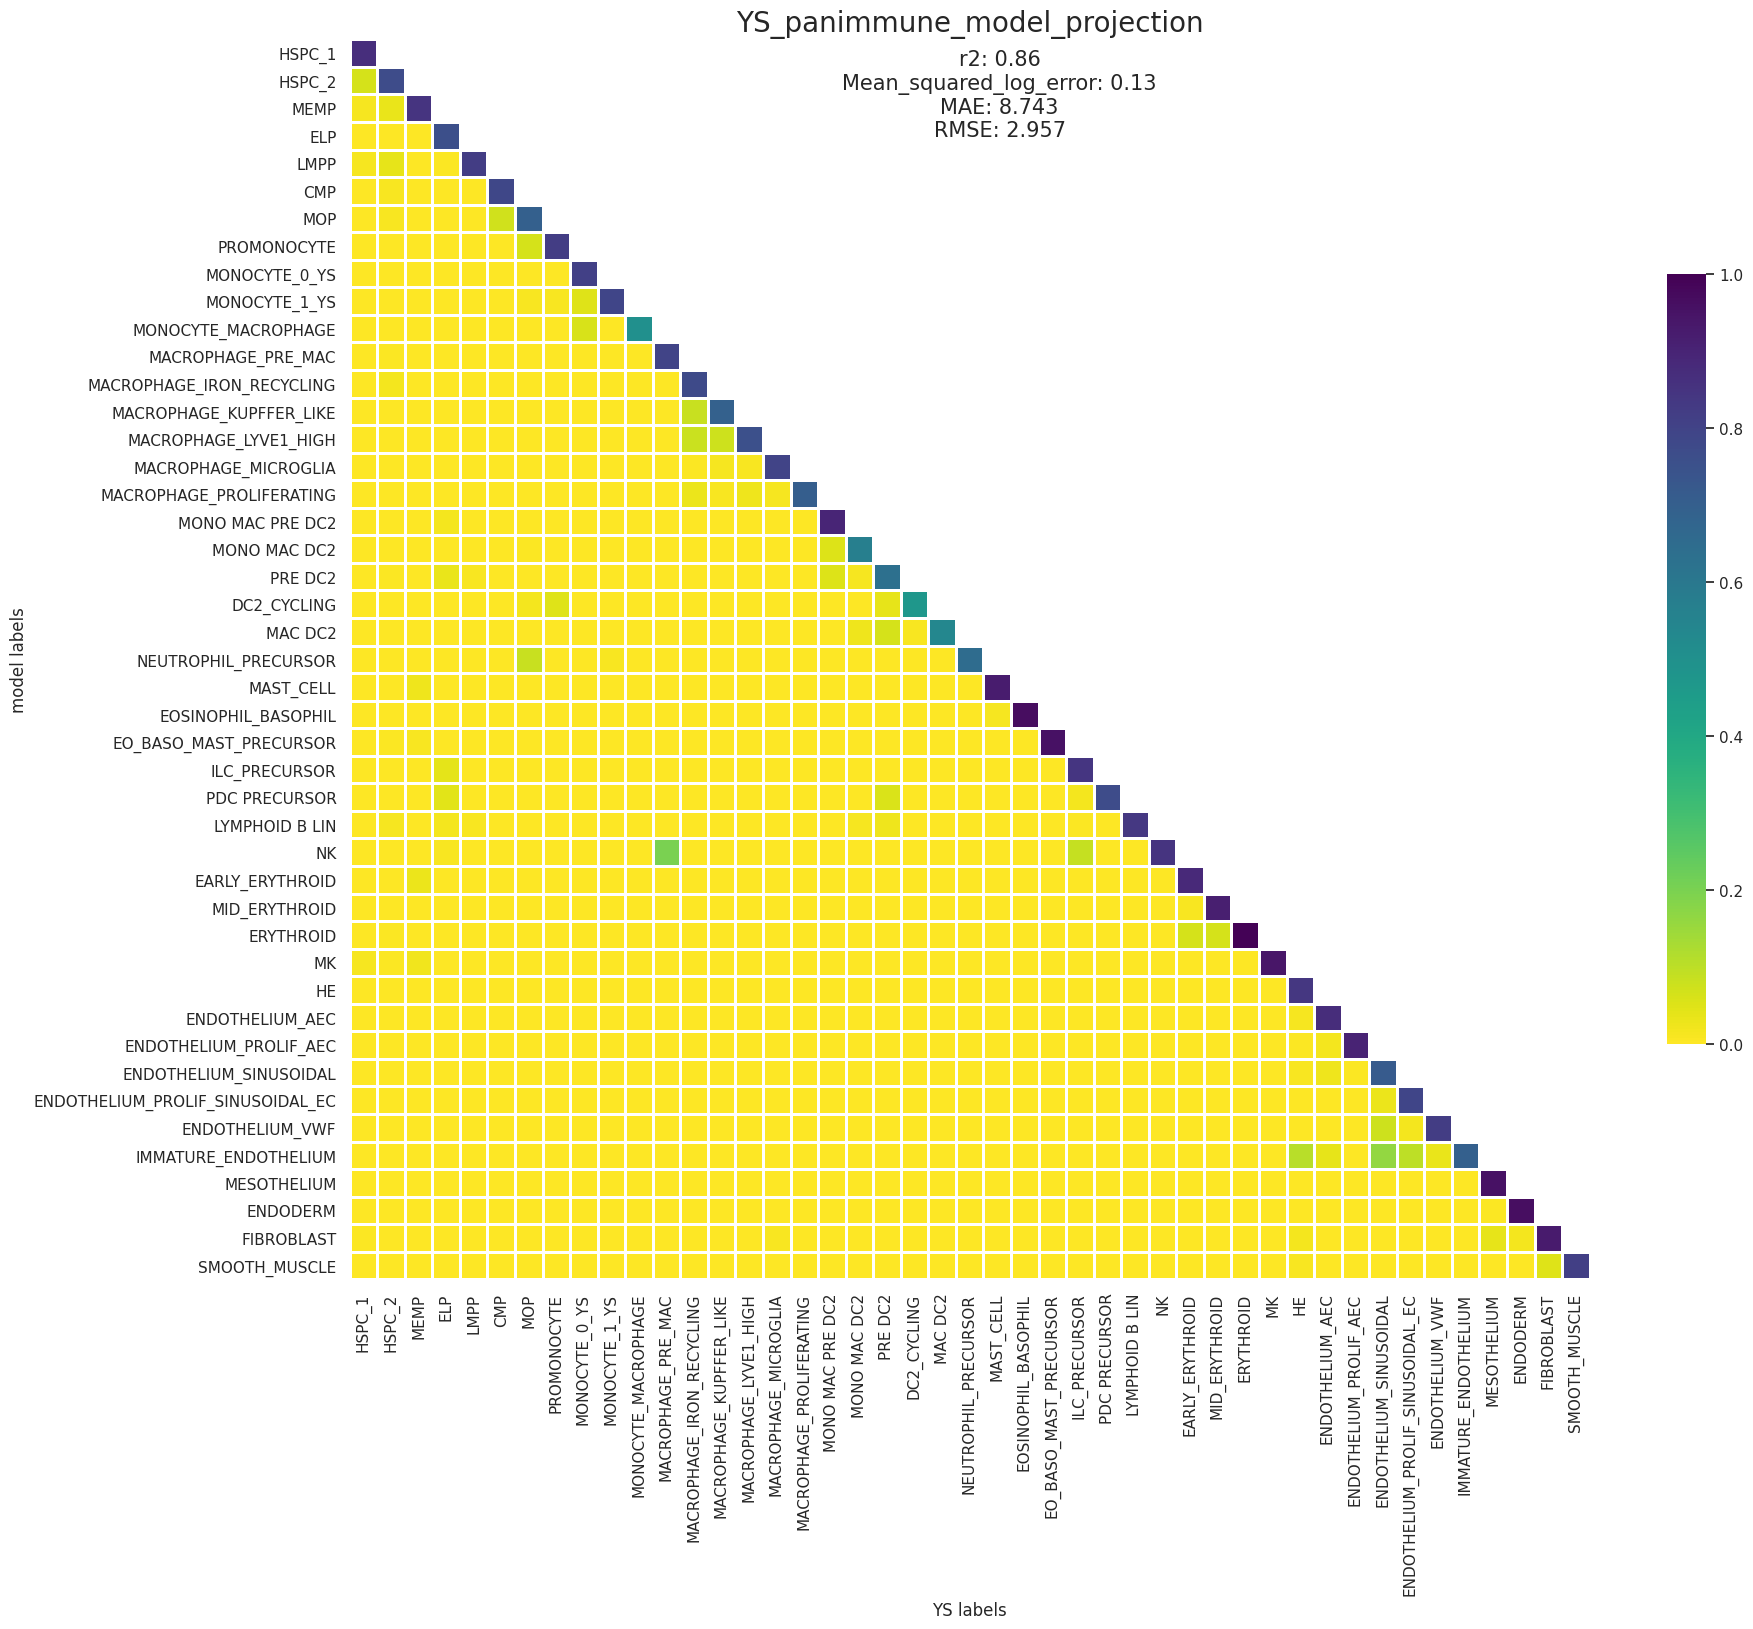

In [216]:
y_true, y_pred =data_temp.obs[feat_use].map(idx_map), data_temp.obs['predicted'].map(idx_map)
explained_variance=metrics.explained_variance_score(y_true, y_pred)
mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
mse=metrics.mean_squared_error(y_true, y_pred) 
mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
r2=metrics.r2_score(y_true, y_pred)

# print('explained_variance: ', round(explained_variance,3))    
# print('mean_squared_log_error: ', round(mean_squared_log_error,3))
# print('r2: ', round(r2,3))
# print('MAE: ', round(mean_absolute_error,3))
# print('MSE: ', round(mse,3))
# print('RMSE: ', round(np.sqrt(mse),3))

# explained_variance = str('Explained_variance: ' + str(round(explained_variance,3)))
r2 = str('r2: ' + str(round(r2,3))) 
mean_squared_log_error = str('Mean_squared_log_error: '+str(round(mean_squared_log_error,3))) 
MAE = str('MAE: ' + str(round(mse,3))) 
RMSE = str('RMSE: ' + str(round(np.sqrt(mse),3)))

order = [
'HSPC_1',    
'HSPC_2',
'MEMP',
'ELP',
'LMPP',
'CMP',
'MOP',
'PROMONOCYTE',
'MONOCYTE_0_YS',
'MONOCYTE_1_YS',
'MONOCYTE_MACROPHAGE',
'MACROPHAGE_PRE_MAC',
'MACROPHAGE_IRON_RECYCLING',
'MACROPHAGE_KUPFFER_LIKE',
'MACROPHAGE_LYVE1_HIGH',
'MACROPHAGE_MICROGLIA',
'MACROPHAGE_PROLIFERATING',
'MONO MAC PRE DC2',
'MONO MAC DC2',
'PRE DC2',
'DC2_CYCLING',
'MAC DC2',
'NEUTROPHIL_PRECURSOR',
'MAST_CELL',
'EOSINOPHIL_BASOPHIL',
'EO_BASO_MAST_PRECURSOR',    
'ILC_PRECURSOR',
'PDC PRECURSOR',
'LYMPHOID B LIN',
'NK', 
'EARLY_ERYTHROID',
'MID_ERYTHROID',
'ERYTHROID', 
'MK',
'HE',
'ENDOTHELIUM_AEC',
'ENDOTHELIUM_PROLIF_AEC',
'ENDOTHELIUM_SINUSOIDAL',
'ENDOTHELIUM_PROLIF_SINUSOIDAL_EC',
'ENDOTHELIUM_VWF',
'IMMATURE_ENDOTHELIUM',
'MESOTHELIUM',
'ENDODERM',
'FIBROBLAST',
'SMOOTH_MUSCLE',
]
df_cm = df_cm.loc[order]
df_cm = df_cm[order]
df_cm = df_cm.round(1)

sns.set(font_scale=1) 
plt.figure(figsize = (20,20))
pal = sns.diverging_palette(240, 10, n=10)
df_lt = df_cm.where(np.tril(np.ones(df_cm.shape)).astype(np.bool))

df_lt = df_lt/100
g = sns.heatmap(df_lt, cmap='viridis_r',  annot=False,vmin=0, vmax=1, linewidths=1, center=0.50, square=True, cbar_kws={"shrink": 0.5})
df_lt.to_csv('./'+out_dir+'/'+'YS'+'_median_ldvae_ver5_ys_lr_model_probs.csv')

f_dict = {'fontsize': 20}
plt.title('YS_panimmune_model_projection', fontdict=f_dict, loc='center', pad=None)
plt.suptitle('{}\n{}\n{}\n{}'.format(r2,mean_squared_log_error,MAE,RMSE), fontsize=15, x=0.45, y=0.8)
plt.ylabel("model labels")
plt.xlabel('YS' + ' labels')

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
g.set_facecolor('xkcd:white')
plt.savefig('./'+out_dir+'_'+'YS_ldvae_model_probs.pdf',  dpi=300, format=None, metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None
       )
plt.show()

In [217]:
df_lt.to_csv('./'+out_dir+'/'+'YS'+'_median_ldvae_ver5_ys_lr_model_probs.csv')

In [192]:
df_lt

,HSPC_1,HSPC_2,MEMP,ELP,LMPP,CMP,MOP,PROMONOCYTE,MONOCYTE_0_YS,MONOCYTE_1_YS,...,ENDOTHELIUM_AEC,ENDOTHELIUM_PROLIF_AEC,ENDOTHELIUM_SINUSOIDAL,ENDOTHELIUM_PROLIF_SINUSOIDAL_EC,ENDOTHELIUM_VWF,IMMATURE_ENDOTHELIUM,MESOTHELIUM,ENDODERM,FIBROBLAST,SMOOTH_MUSCLE
HSPC_1,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSPC_2,6.6,77.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MEMP,1.4,3.2,85.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ELP,0.3,0.2,0.0,76.1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LMPP,1.3,3.9,0.3,0.6,82.1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CMP,0.1,0.8,0.0,0.0,0.0,78.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MOP,0.1,0.9,0.1,0.0,0.0,7.1,69.6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PROMONOCYTE,0.0,0.3,0.0,0.0,0.0,0.0,6.3,82.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MONOCYTE_0_YS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MONOCYTE_1_YS,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.8,4.8,79.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Create Cross-organ projections and save plots

In [94]:
organ_keys = ['SK', 'SP', 'LI', 'TH', 'GU', 'BM', 'KI', 'MLN', 'BR', 'GO', 'AGM']
model_key = 'YS_v3_macs_mod_ldvae_panf_model'
out_dir = './A1_V8_YS_model_pan_organ_heatmaps'
train_x_partition = 'X_scvi'
feat_use = 'LVL3'
remove_class = ['OSTEOCLAST']

In [96]:
order = [
'HSPC_1',    
'HSPC_2',
'MEMP',
'ELP',
'LMPP',
'CMP',
'MOP',
'PROMONOCYTE',
'MONOCYTE_0_YS',
'MONOCYTE_1_YS',
'MONOCYTE_MACROPHAGE',
'MACROPHAGE_PRE_MAC',
'MACROPHAGE_IRON_RECYCLING',
'MACROPHAGE_KUPFFER_LIKE',
'MACROPHAGE_LYVE1_HIGH',
'MACROPHAGE_MICROGLIA',
'MACROPHAGE_PROLIFERATING',
'MONO MAC PRE DC2',
'MONO MAC DC2',
'PRE DC2',
'DC2_CYCLING',
'MAC DC2',
'NEUTROPHIL_PRECURSOR',
'MAST_CELL',
'EOSINOPHIL_BASOPHIL',
'EO_BASO_MAST_PRECURSOR',    
'ILC_PRECURSOR',
'PDC PRECURSOR',
'LYMPHOID B LIN',
'NK', 
'EARLY_ERYTHROID',
'MID_ERYTHROID',
'ERYTHROID', 
'MK',
'HE',
'ENDOTHELIUM_AEC',
'ENDOTHELIUM_PROLIF_AEC',
'ENDOTHELIUM_SINUSOIDAL',
'ENDOTHELIUM_PROLIF_SINUSOIDAL_EC',
'ENDOTHELIUM_VWF',
'IMMATURE_ENDOTHELIUM',
'MESOTHELIUM',
'ENDODERM',
'FIBROBLAST',
'SMOOTH_MUSCLE',
]

SK
{low_dim: this partition modality is still under development!}


<ipython-input-190-9d8c926b9628>:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_temp.obs['predicted'] = pred_out['predicted']


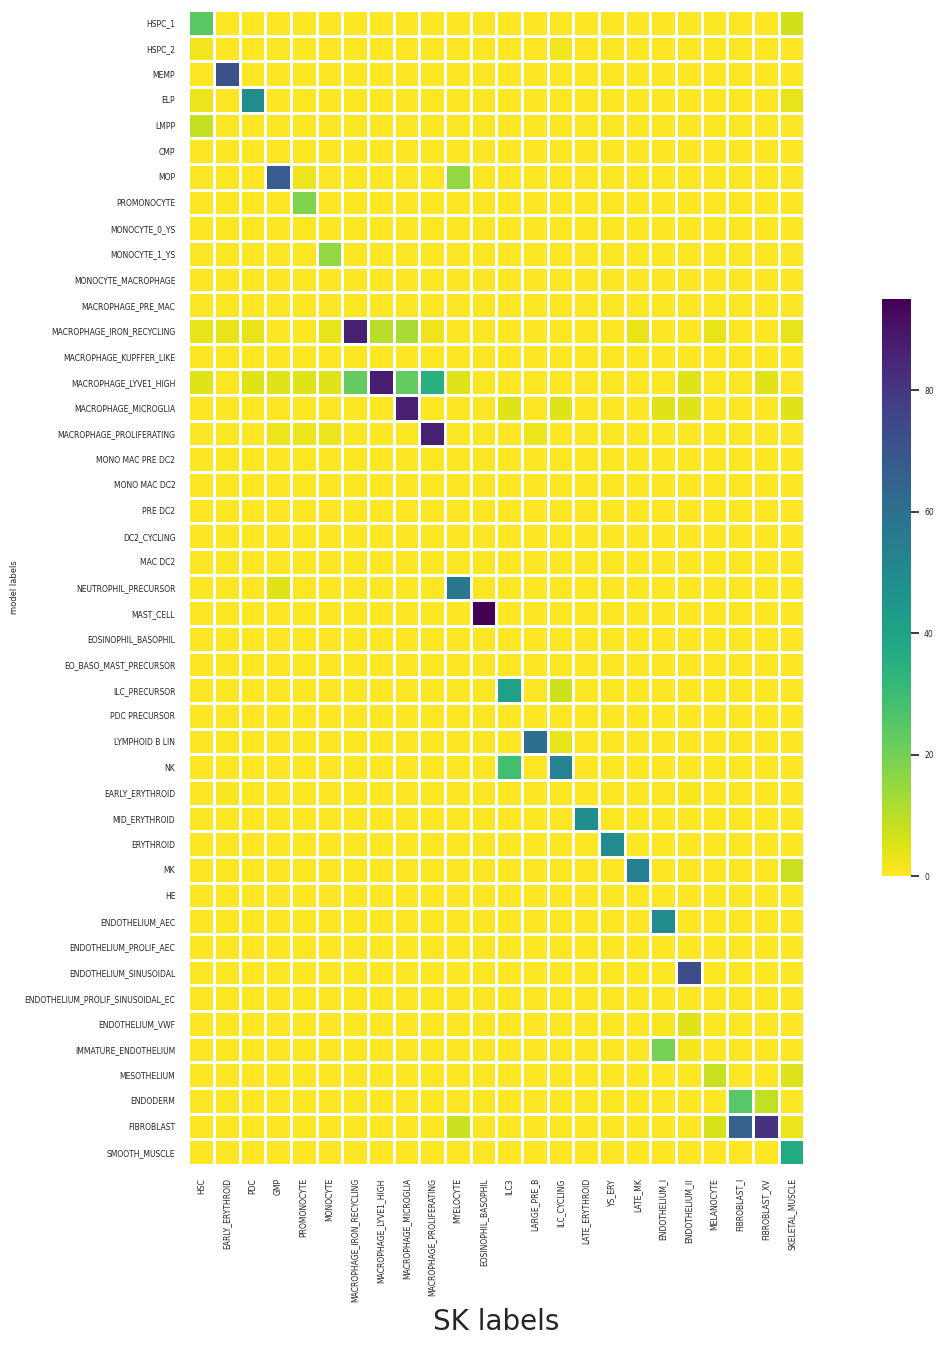

SP
{low_dim: this partition modality is still under development!}


<ipython-input-190-9d8c926b9628>:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_temp.obs['predicted'] = pred_out['predicted']


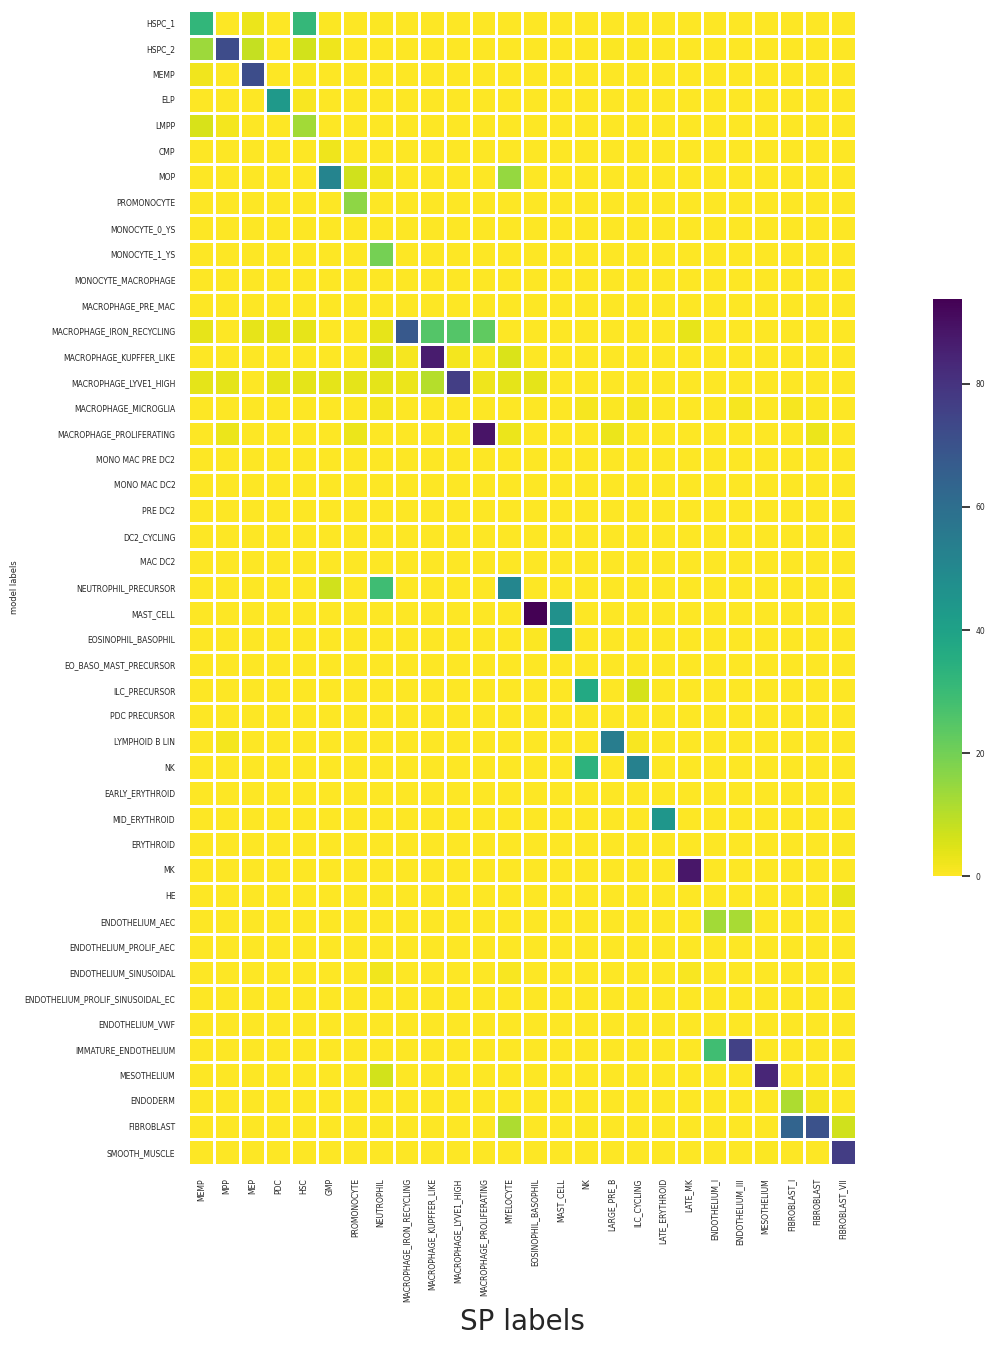

LI
{low_dim: this partition modality is still under development!}


<ipython-input-190-9d8c926b9628>:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_temp.obs['predicted'] = pred_out['predicted']


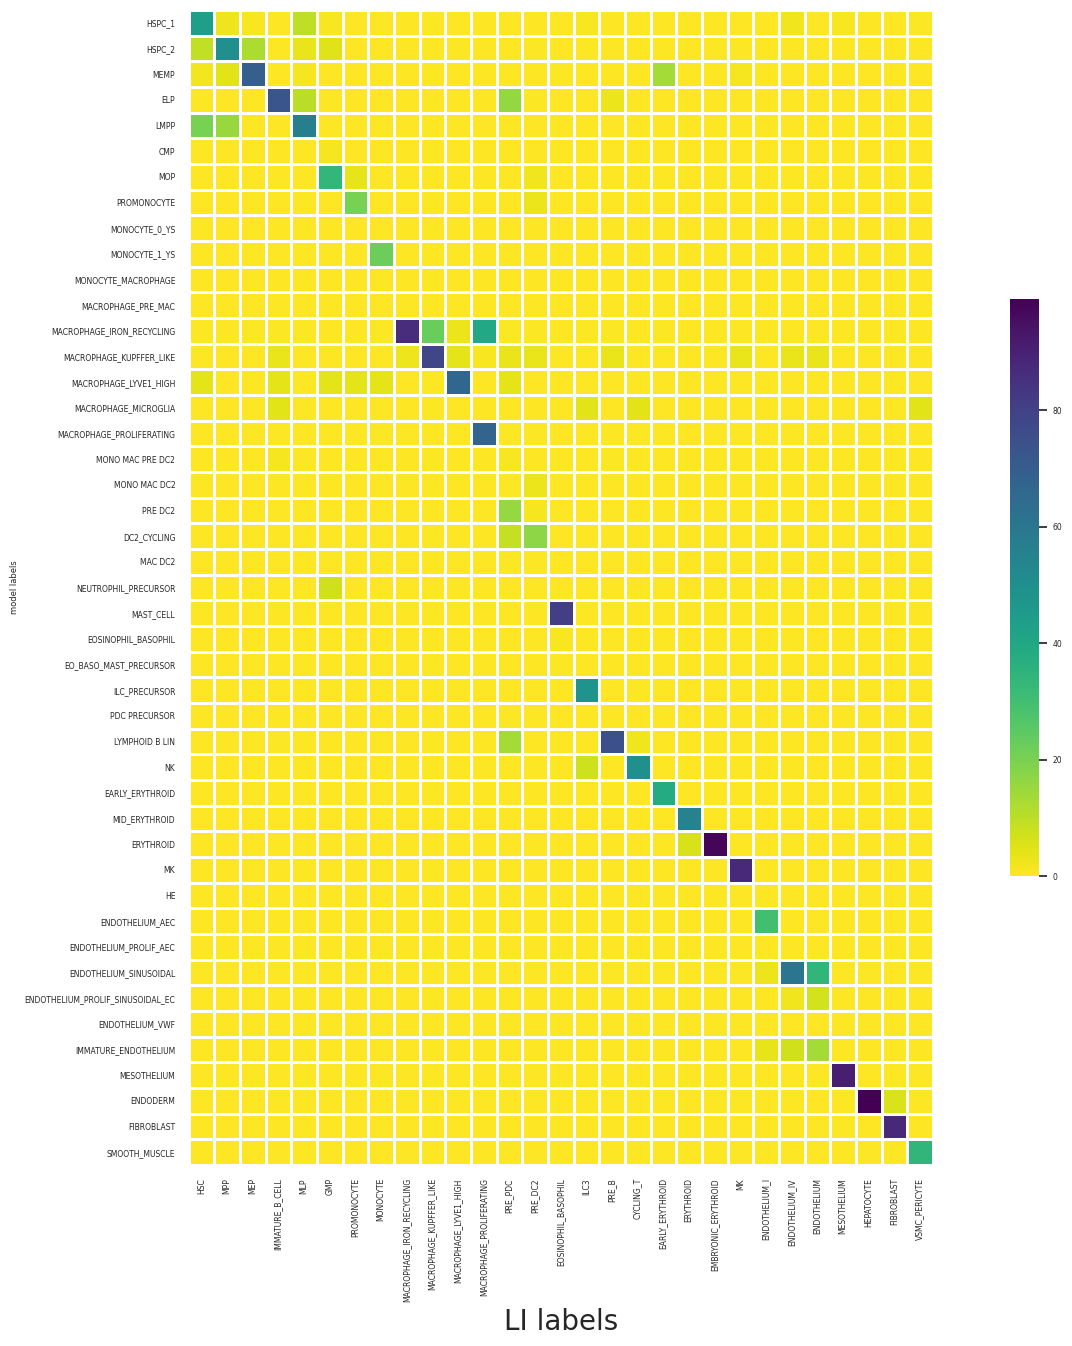

TH
{low_dim: this partition modality is still under development!}


<ipython-input-190-9d8c926b9628>:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_temp.obs['predicted'] = pred_out['predicted']


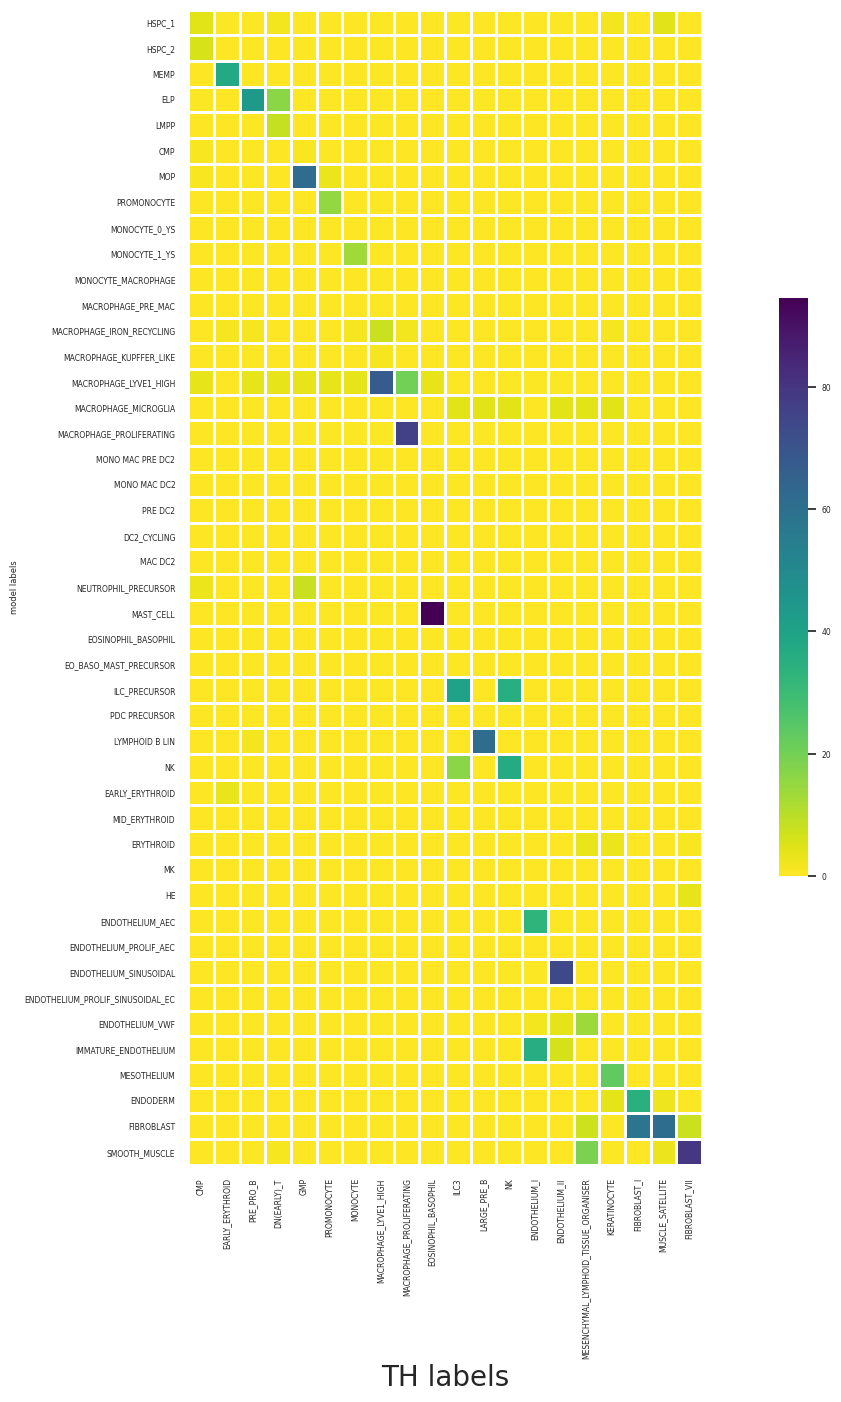

GU
{low_dim: this partition modality is still under development!}


<ipython-input-190-9d8c926b9628>:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_temp.obs['predicted'] = pred_out['predicted']


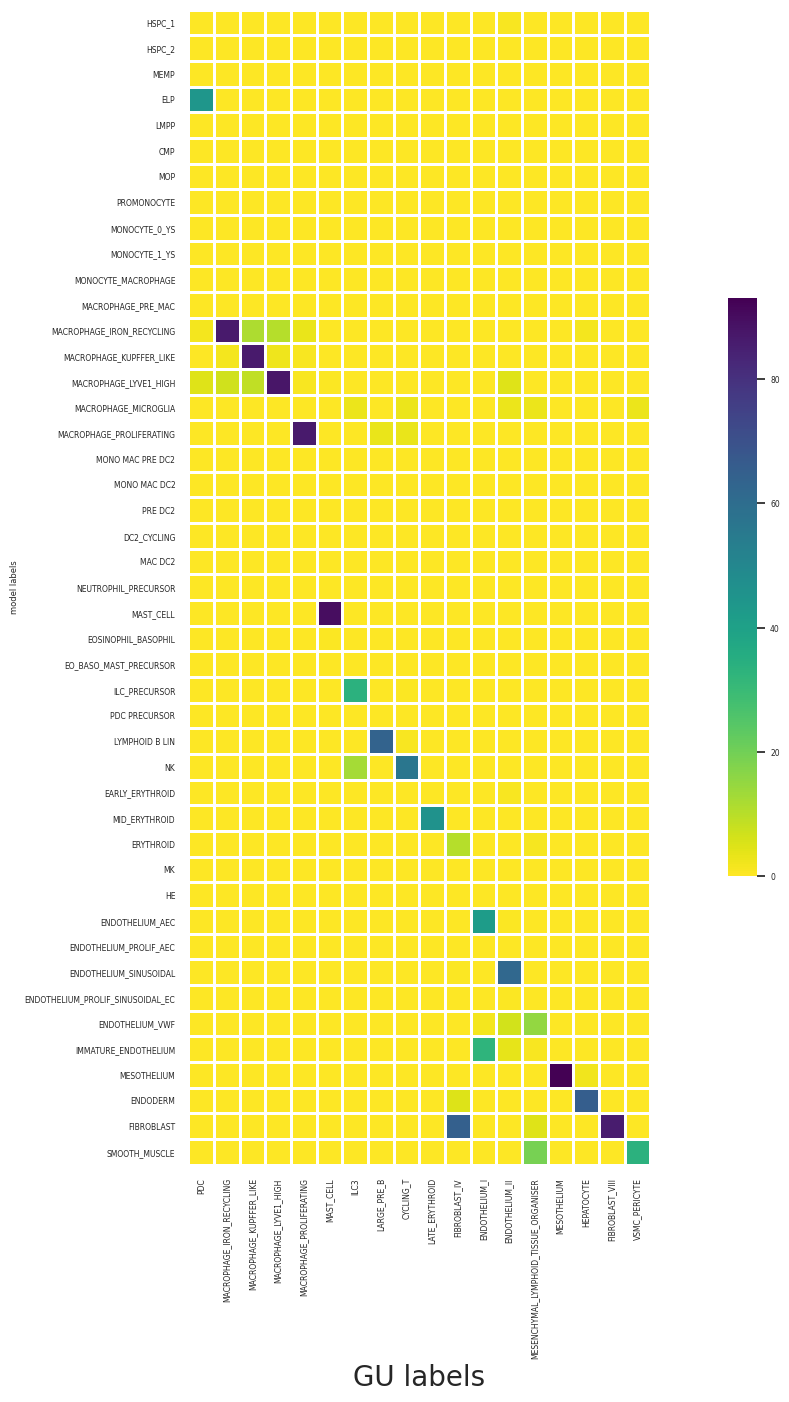

BM
{low_dim: this partition modality is still under development!}


<ipython-input-190-9d8c926b9628>:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_temp.obs['predicted'] = pred_out['predicted']


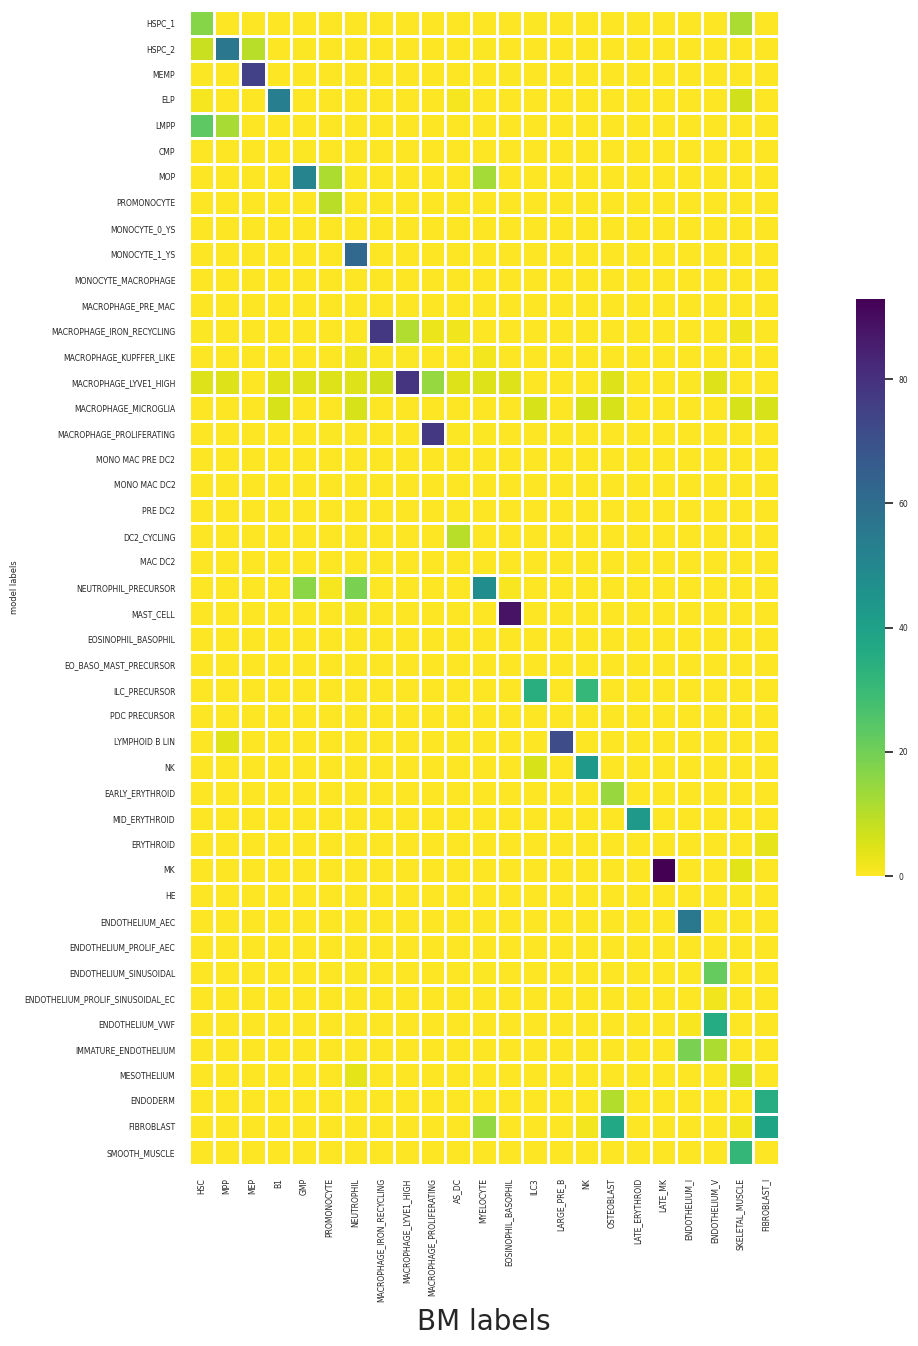

KI
{low_dim: this partition modality is still under development!}


<ipython-input-190-9d8c926b9628>:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_temp.obs['predicted'] = pred_out['predicted']


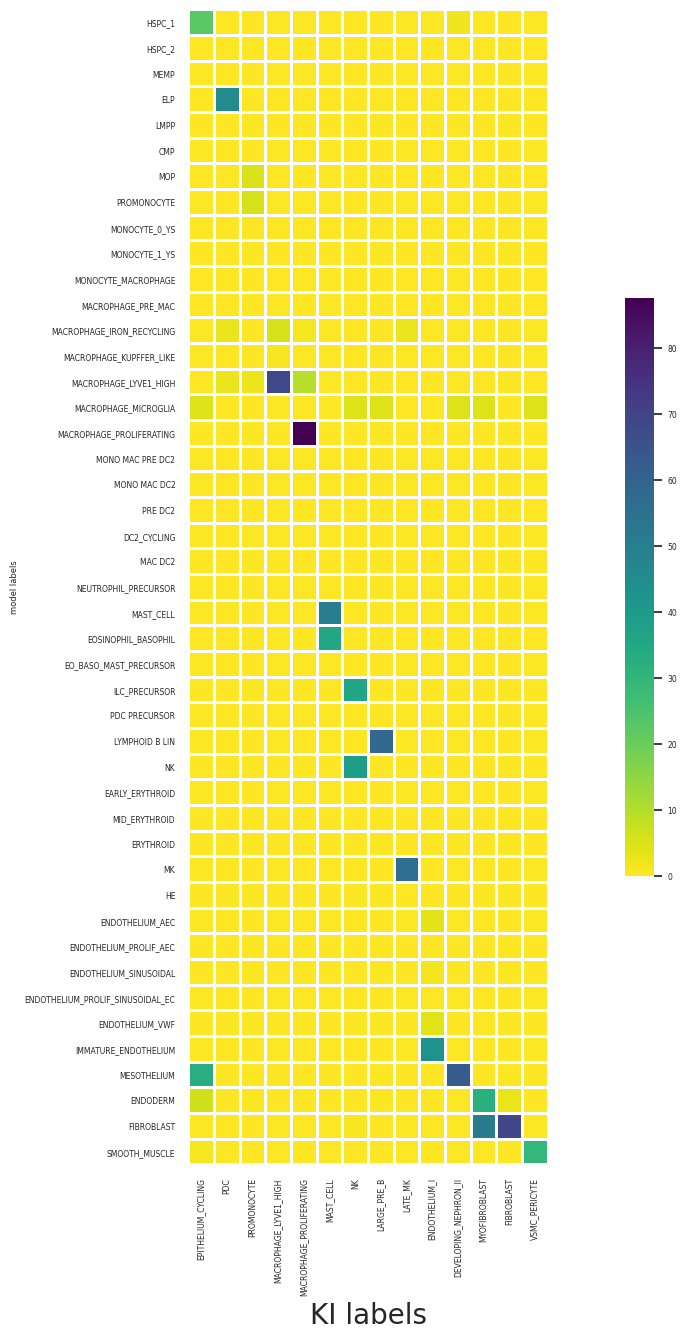

MLN
{low_dim: this partition modality is still under development!}


<ipython-input-190-9d8c926b9628>:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_temp.obs['predicted'] = pred_out['predicted']


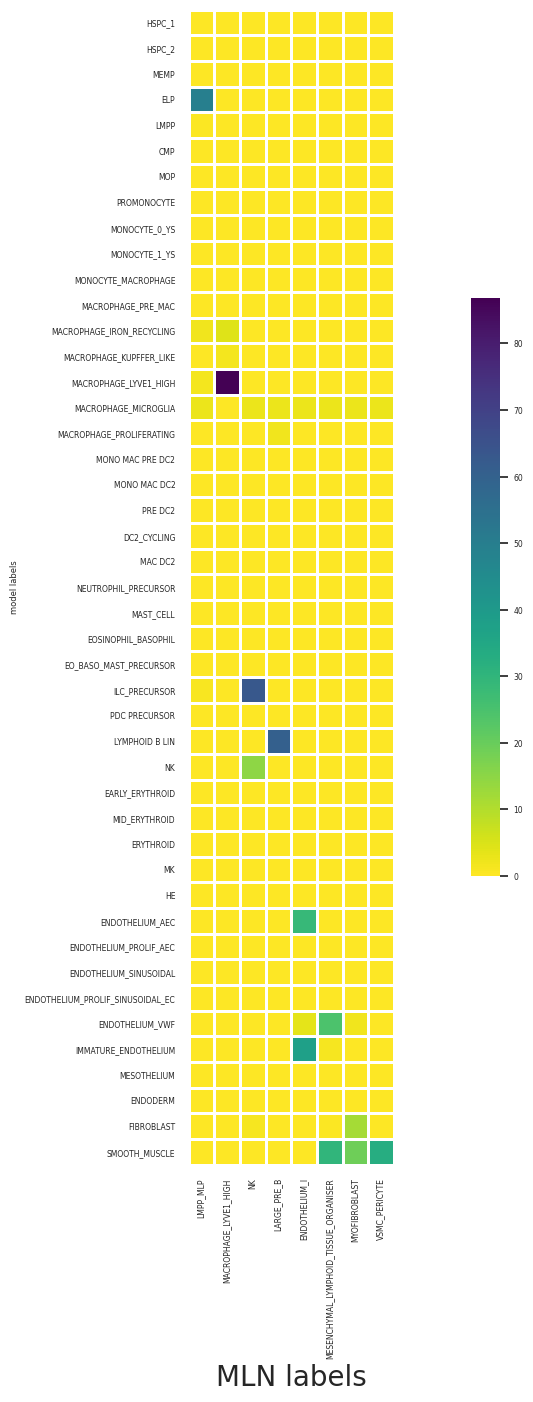

BR
{low_dim: this partition modality is still under development!}


<ipython-input-190-9d8c926b9628>:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_temp.obs['predicted'] = pred_out['predicted']


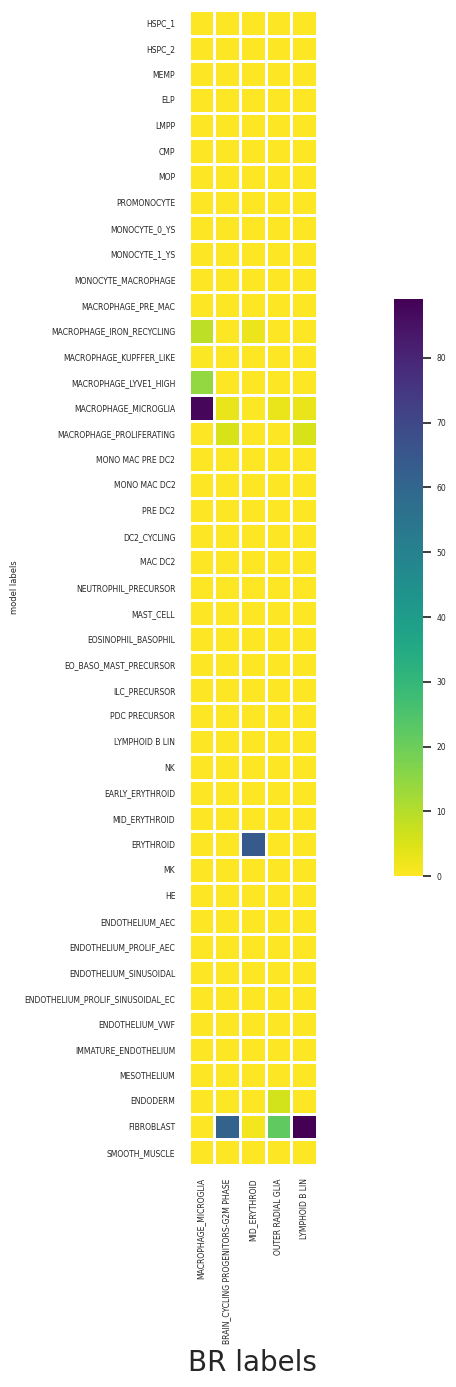

GO
{low_dim: this partition modality is still under development!}


<ipython-input-190-9d8c926b9628>:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_temp.obs['predicted'] = pred_out['predicted']


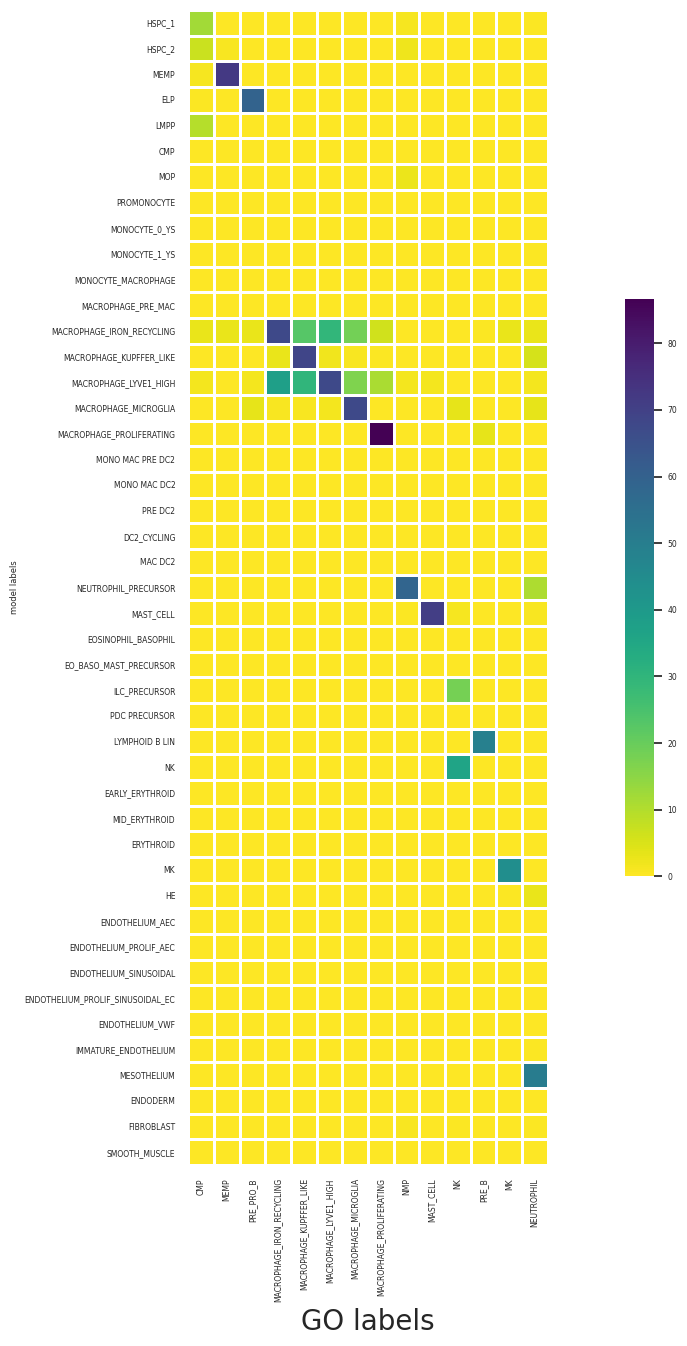

AGM
{low_dim: this partition modality is still under development!}


<ipython-input-190-9d8c926b9628>:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data_temp.obs['predicted'] = pred_out['predicted']


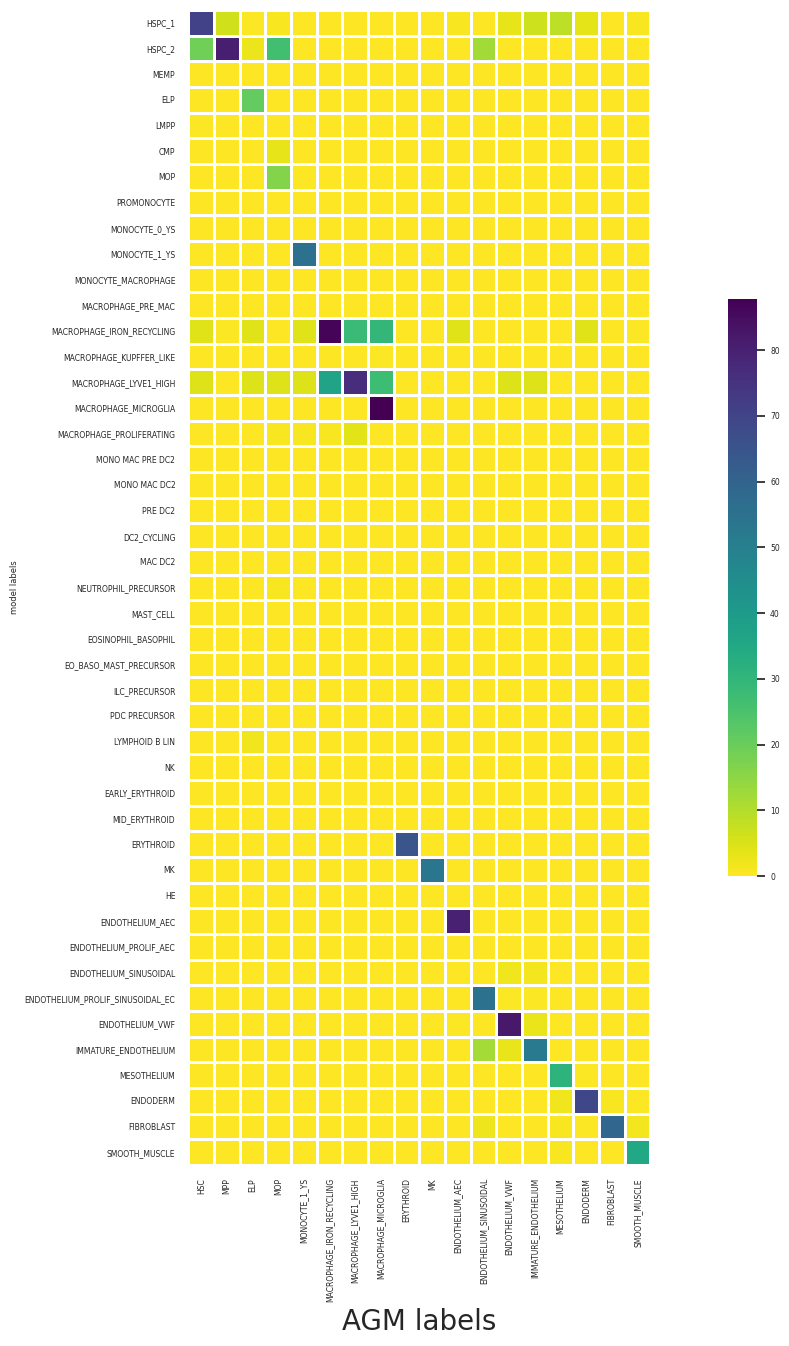

In [190]:
import os
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for org_key in organ_keys: #['SK']:
    print(org_key)
    adata_ys = adata[adata.obs['organ'].isin([org_key])]
    keep = (list(adata_ys.obs.groupby([feat_use]).apply(len)[adata_ys.obs.groupby([feat_use]).apply(len)>30].index))
    adata_ys = adata_ys[adata_ys.obs[feat_use].isin(keep)]

    data_temp = adata_ys[:]
    model_lr = load_models(models,model_key)

    print('{low_dim: this partition modality is still under development!}')
    train_x = data_temp.obsm[train_x_partition][:]
    pred_out = pd.DataFrame(model_lr.predict(train_x),columns = ['predicted'],index = list(data_temp.obs.index))
    proba =  pd.DataFrame(model_lr.predict_proba(train_x),columns = model_lr.classes_,index = list(data_temp.obs.index))
    pred_out = pred_out.join(proba)
    data_temp.obs['predicted'] = pred_out['predicted']


    pred_out['orig_labels'] = data_temp.obs[feat_use]
    model_mean_probs = pred_out.loc[:, pred_out.columns != 'predicted'].groupby('orig_labels').median()
    model_mean_probs = model_mean_probs*100
    model_mean_probs = model_mean_probs.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

    crs_tbl = model_mean_probs.copy()
    order_in = list(sorted(set(order) & set(list(crs_tbl.columns)), key = order.index))
    crs_tbl = crs_tbl[order_in]
    
    #Mac mono modifier
    bs = crs_tbl.loc[(crs_tbl.index.str.contains('MONOCYTE')),list((crs_tbl.columns[crs_tbl.columns.str.contains('MACROPHAGE_')]))] 
    bs = list(bs.max(axis = 0)[bs.max(axis = 0)>10].index)
    crs_tbl.loc[(crs_tbl.index.str.contains('MONOCYTE')),bs ]  = 3.788
    for z in list((crs_tbl.columns[crs_tbl.columns.str.contains('MACROPHAGE_')])):
        crs_tbl.loc[(crs_tbl[z]>0.5) & (~crs_tbl[z].index.str.contains('MACROPHAGE_')),z] = float( (np.random.randint(0,6,1)) + (np.random.randint(2,9,1)/10)+ (np.random.randint(0,9,1)/100))
        crs_tbl.loc[(crs_tbl[z]>40) & (~crs_tbl[z].index.str.contains(z)),z] = float( (np.random.randint(0,3,1))*10 + (np.random.randint(0,9,1)) + (np.random.randint(0,9,1)/10)+ (np.random.randint(0,9,1)/100))
        
    for i in list(set(list(crs_tbl.loc[crs_tbl.index.str.contains('MACROPHAGE_')].index)) & set(list((crs_tbl.columns[crs_tbl.columns.str.contains('MACROPHAGE_')])))):
        crs_tbl.loc[i,i] = float((int(np.random.randint(6,9,1))*10 )+ (np.random.randint(6,9,1)) + (np.random.randint(6,9,1)/10))
        
    df = crs_tbl[:]
    ps_order = []
    inx_li = list(range(0,len(df.columns)))
    for inx in inx_li:
        if df.iloc[:,inx].sort_values(ascending=False).head(1).values <5 :
            pos = []
        else:
            pos = list(df.iloc[:,inx].sort_values(ascending=False).head(1).index)
        ps_order = ps_order + (pos)
    order_pr = []
    for n in ps_order:
        if n not in order_pr:
            order_pr.append(n)
    crs_tbl = crs_tbl.loc[order_pr]


    # Standardise
#     crs_tbl = (crs_tbl-crs_tbl.min())/(crs_tbl.max()-crs_tbl.min())
#     crs_tbl = crs_tbl.fillna(0)
    
    pal = sns.diverging_palette(240, 10, n=10)
    plt.figure(figsize=(20,15))
    sns.set(font_scale=0.5)
    g = sns.heatmap(crs_tbl.T, cmap='viridis_r',  annot=False,vmin=0, vmax=max(np.max(crs_tbl)), linewidths=1, center=max(np.max(crs_tbl))/2, square=True, cbar_kws={"shrink": 0.5})
    crs_tbl.T.to_csv('./'+out_dir+'/'+org_key+'_median_ldvae_ver5_ys_lr_model_probs.csv')
    
    plt.ylabel("model labels")
    plt.xlabel(org_key + ' labels',fontsize=20)
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['pdf.fonttype'] = 42['svg.fonttype'] = 'none'
    plt.rcParams['pdf.fonttype'] = 42
    plt.savefig('./'+out_dir+'/'+org_key+'_median_ldvae_ver5_ys_lr_model_probs.pdf',dpi=300)
    plt.show()

#     print('Create class standardised projection from highest prob projection')
#     crs_tbl = pd.crosstab(pred_out['orig_labels'],pred_out['predicted'])
#     order_in = list(sorted(set(order) & set(list(crs_tbl.columns)), key = order.index))
#     crs_tbl = crs_tbl[order_in]
    
#     crs_tbl = (crs_tbl-crs_tbl.min())/(crs_tbl.max()-crs_tbl.min())
#     crs_tbl = crs_tbl.fillna(0)
    
#     #Mac mono modifier
#     bs = crs_tbl.loc[(crs_tbl.index.str.contains('MONOCYTE')),list((crs_tbl.columns[crs_tbl.columns.str.contains('MACROPHAGE_')]))] 
#     bs = list(bs.max(axis = 0)[bs.max(axis = 0)>0.01].index)
#     crs_tbl.loc[(crs_tbl.index.str.contains('MONOCYTE')),bs ]  = 0.03788
#     for z in list((crs_tbl.columns[crs_tbl.columns.str.contains('MACROPHAGE_')])):
#         crs_tbl.loc[(crs_tbl[z]>0.5) & (~crs_tbl[z].index.str.contains('MACROPHAGE_')),z] = float( (np.random.randint(0,9,1)/10) + (np.random.randint(6,9,1)/100))
#     for i in list(set(list(crs_tbl.loc[crs_tbl.index.str.contains('MACROPHAGE_')].index)) & set(list((crs_tbl.columns[crs_tbl.columns.str.contains('MACROPHAGE_')])))):
#         crs_tbl.loc[i,i] = float((int(np.random.randint(6,9,1))/10 )+ (np.random.randint(6,9,1)/100) + (np.random.randint(6,9,1)/1000))
    
#     df = crs_tbl[:]
#     ps_order = []
#     inx_li = list(range(0,len(df.columns)))
#     for inx in inx_li:
#         if df.iloc[:,inx].sort_values(ascending=False).head(1).values <0.1 :
#             pos = []
#         else:
#             pos = list(df.iloc[:,inx].sort_values(ascending=False).head(3).index)
#         ps_order = ps_order + (pos)
#     order_pr = []
#     for n in ps_order:
#         if n not in order_pr:
#             order_pr.append(n)
    
    
#     crs_tbl = crs_tbl.loc[order_pr]
#     pal = sns.diverging_palette(240, 10, n=10)
#     plt.figure(figsize=(20,15))
#     sns.set(font_scale=0.5)
#     g = sns.heatmap(crs_tbl.T, cmap='viridis_r',  annot=False,vmin=0, vmax=max(np.max(crs_tbl)), linewidths=1, center=max(np.max(crs_tbl))/2, square=True, cbar_kws={"shrink": 0.5})

#     plt.ylabel("model labels")
#     plt.xlabel(org_key + ' labels')
#     plt.savefig('./'+out_dir+'/'+org_key+'_standardised_discriminatatory_ldvae_ver5_ys_lr_model_probs.pdf',dpi=300)
#     plt.show()